In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import awkward as ak

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/event_based/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_trk_pt = f["trk_pT"].array()
    jet_trk_eta = f["trk_eta"].array()
    jet_trk_phi = f["trk_phi"].array()
    jet_trk_q = f["trk_q"].array()
    jet_trk_d0 = f["trk_d0"].array()
    jet_trk_z0 = f["trk_z0"].array()
    jet_trk_label = f["trk_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()

### Associate Tracks to Jets

In [3]:
%%time
num_events = len(jet_pt)
trk_feats = []
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    idx_list = list(jet_trk_IDX[event])
    idx_list.append(len(jet_trk_pt[event]))
    
    jet_trk_feats = []
    for i in range(len(idx_list)-1):
        start_idx = idx_list[i]
        end_idx = idx_list[i+1]-1 
        trk_pt_tmp = np.array(jet_trk_pt[event][start_idx:end_idx])
        trk_eta_tmp = np.array(jet_trk_eta[event][start_idx:end_idx])
        trk_phi_tmp = np.array(jet_trk_phi[event][start_idx:end_idx])
        trk_q_tmp = np.array(jet_trk_q[event][start_idx:end_idx])
        trk_d0_tmp = np.array(jet_trk_d0[event][start_idx:end_idx])
        trk_z0_tmp = np.array(jet_trk_z0[event][start_idx:end_idx])
        trk_label_tmp = np.array(jet_trk_label[event][start_idx:end_idx])

        feats = [trk_pt_tmp, trk_eta_tmp, trk_phi_tmp, trk_q_tmp,
                trk_d0_tmp, trk_z0_tmp, trk_label_tmp]
        feats = np.stack(feats, axis=-1)
        jet_trk_feats.append(feats)
    
    trk_feats.append(jet_trk_feats)
    
trk_feats = ak.Array(trk_feats)

print()
print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Processing:  995  /  1000
Num Events:  1000
Num Jets in first event:  22
Num Tracks in first event first jet:  82
Num Tracks features:  7
CPU times: user 23.2 s, sys: 151 ms, total: 23.3 s
Wall time: 23.3 s


In [4]:
%%time
num_events = len(jet_pt)
jet_feats = []
for event in range(num_events):
    jet_pt_tmp = np.array(jet_pt[event])
    jet_eta_tmp = np.array(jet_eta[event])
    jet_phi_tmp = np.array(jet_phi[event])

    feats = [jet_pt_tmp, jet_eta_tmp, jet_phi_tmp]
    feats = np.stack(feats, axis=-1)
    
    jet_feats.append(feats)
    
jet_feats = ak.Array(jet_feats)

print(jet_feats)
print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

[[[146, -0.157, 2.52], [113, ..., 0.0962], ..., [26.7, -2.63, 4.82]], ...]
Num Events:  1000
Num Jets in first event:  22
Num Jet Features:  3
CPU times: user 510 ms, sys: 3.22 ms, total: 513 ms
Wall time: 506 ms


### Define Jet Class

In [5]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def set_binary_label(self):
        if self.label == 0:
            self.binary_label = np.float32(0)
        else:
            self.binary_label = np.float32(1)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])
        self.binary_label = torch.tensor(self.binary_label).reshape([1])
        
    def norm_data(self, jet_means, trk_means, jet_stds, trk_stds):
        self.jet_features = torch.div(torch.sub(self.jet_features,jet_means),jet_stds)
        self.trk_features = torch.div(torch.sub(self.trk_features,trk_means),trk_stds)

### Apply Cuts, Read data into Jet class, and store on Event Basis

Processing:  995  /  1000
Training Events:  600
Validation Events:  100
Testing Events:  300
CPU times: user 1min 16s, sys: 283 ms, total: 1min 16s
Wall time: 1min 16s


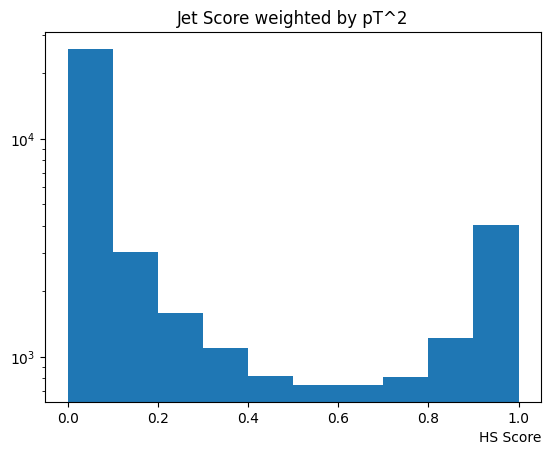

In [6]:
%%time     
Event_Jet_List = []
num_events = len(jet_pt)
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    Jet_List = []
    num_jets = len(jet_feats[event])
    jet_eta_cut = jet_feats[event]
    for jet in range(num_jets):
        if abs(jet_feats[event][jet][1])>4:
            continue
        
        trk_q_cut = trk_feats[event][jet][:,3]!=0
        trk_eta_cut = abs(trk_feats[event][jet][:,1])<4
        trk_pt_cut = trk_feats[event][jet][:,0]>0.4
        
        mask = trk_q_cut & trk_eta_cut & trk_pt_cut
        #not_mask = ~mask
        
        pass_trks = trk_feats[event][jet][mask]
        #fail_trks = trk_feats[event][jet][not_mask]
        
        jet_f = np.array(jet_feats[event][jet], dtype=np.float32)
        trk_f = np.array(pass_trks[:,0:-1], dtype=np.float32)
        trk_l = np.array(pass_trks[:,-1], dtype=np.float32)
        
        Jet_List.append(Jet(jet_f,trk_f,trk_l))
        
    Event_Jet_List.append(Jet_List)
    
random.shuffle(Event_Jet_List)

Events_training = Event_Jet_List[0:int(0.6*num_events)]
Events_validation = Event_Jet_List[int(0.6*num_events):int(0.7*num_events)]
Events_testing = Event_Jet_List[int(0.7*num_events):]

print()
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

label = []
for event in range(num_events):
    for jet in Event_Jet_List[event]:
        jet.set_label(jet.get_label())
        jet.set_binary_label()
        jet.convert_to_tensor()
        
        # List for plotting labels
        label.append(float(jet.label))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Pad Number of Tracks per Jet

In [7]:
print("Before:")
len_list = []
for i in range(len(Event_Jet_List[0])):
    len_list.append(len(Event_Jet_List[0][i].trk_features))
print("Max: ", max(len_list))
print("Min: ", min(len_list))

num_events = len(Event_Jet_List)
for event in range(num_events):
    max_list = []
    for jet in Event_Jet_List[event]:
        max_list.append(len(jet.trk_features))
    max_num_trks = max(max_list)
    
    for jet in Event_Jet_List[event]:
        pad = (0,0,0,max_num_trks-len(jet.trk_features))
        out_trk = F.pad(jet.trk_features,pad)
        jet.trk_features = out_trk

print("After:")
len_list = []
for i in range(len(Event_Jet_List[0])):
    len_list.append(len(Event_Jet_List[0][i].trk_features))
print("Max: ", max(len_list))
print("Min: ", min(len_list))

Before:
Max:  28
Min:  10
After:
Max:  28
Min:  28


### Define Dataloader

In [8]:
def dataloader(Jet_list):
    
    jet_tensor = []
    trk_tensor = []
    MSE_labels = []
    BCE_labels = []
    
    for jet in Jet_list:
        jet_tensor.append(torch.unsqueeze(jet.jet_features,0))
        trk_tensor.append(torch.unsqueeze(jet.trk_features,0))
        MSE_labels.append(torch.unsqueeze(jet.label,0))
        BCE_labels.append(torch.unsqueeze(jet.binary_label,0))
        
    jet_tensor = torch.cat(jet_tensor)
    trk_tensor = torch.cat(trk_tensor)
    MSE_labels = torch.cat(MSE_labels)
    BCE_labels = torch.cat(BCE_labels)
    
    return jet_tensor, trk_tensor, MSE_labels, BCE_labels
        
jet_tensor, trk_tensor, MSE_labels, BCE_labels = dataloader(Events_training[0])
print(jet_tensor.shape)
print(trk_tensor.shape)
print(MSE_labels.shape)
print(BCE_labels.shape)

torch.Size([16, 3])
torch.Size([16, 28, 6])
torch.Size([16, 1])
torch.Size([16, 1])


### Define Model

In [9]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 16
        self.num_jet_feats = 3
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        
        self.multihead_attn_jet = nn.MultiheadAttention(self.embed_dim*2, self.num_heads,batch_first=True)
        self.multihead_attn_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)
        
        self.regression = nn.Linear(self.embed_dim*2, 1)
        self.classification = nn.Linear(self.embed_dim*2, 1)
        
    def forward(self, jets, trks):
        # Feature preprocessing layers
        trk_init = F.relu(self.trk_initializer(trks))
        jet_init = F.relu(self.jet_initializer(jets))
        
        # Calculate aggregated tracks using attention
        query = trk_init
        key = trk_init
        value = trk_init
        trk_embedding, trk_weights = self.multihead_attn_trk(query, key, value)
        trk_aggregated = trk_embedding.sum(dim=1)
        
        # Generate meaningful jet_embedding using info from trk_aggregated           
        jet_embedding = torch.cat((jet_init, trk_aggregated),1)
        
        # Update embeddings of jets in the contex of entire event
        query = jet_embedding
        key = jet_embedding
        value = jet_embedding
        jet_embedding, jet_weights = self.multihead_attn_jet(query, key, value)
        
        # Get two outputs
        output = F.sigmoid(self.regression(jet_embedding))
        binary_classification = F.sigmoid(self.classification(jet_embedding))
        
        return output, binary_classification, jet_weights, trk_weights

In [10]:
model = Model()
print(model)
print(model(jet_tensor,trk_tensor))

Model(
  (jet_initializer): Linear(in_features=3, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (multihead_attn_jet): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (regression): Linear(in_features=512, out_features=1, bias=True)
  (classification): Linear(in_features=512, out_features=1, bias=True)
)
(tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>), tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [3.0012e-04],
        [1.0000e

### Define Training Loop

In [11]:
def train(model, data, epochs=20):
    train_data, validation_data = data
    
    combined_history = []
    mse_history = []
    bce_history = []
    
    num_train = len(Events_training)
    num_val = len(Events_validation)
    
    for e in range(epochs):
        model.train()
        cumulative_MSE_train = 0
        cumulative_BCE_train = 0
        cumulative_loss_train = 0

        for i in range(num_train):
            jets_train, trks_train, train_labels, train_bin_labels = dataloader(Events_training[i])
    
            optimizer.zero_grad()
            
            output, binary, weights_jet, weight_trk = model(jets_train.to(device), trks_train.to(device))
            
            loss_MSE=loss_fn1(output, train_labels.to(device))
            loss_BCE=loss_fn2(binary, train_bin_labels.to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_train+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_train+=loss_BCE.detach().cpu().numpy().mean()

        cumulative_loss_train = cumulative_loss_train / num_train
        cumulative_MSE_train = cumulative_MSE_train / num_train
        cumulative_BCE_train = cumulative_BCE_train / num_train

        
        model.eval()
        cumulative_MSE_val = 0
        cumulative_BCE_val = 0
        cumulative_loss_val = 0
        for i in range(num_val):
            jets_val, trks_val, val_labels, val_bin_labels = dataloader(Events_validation[i])
            output, binary, jet_weights, trk_weights = model(jets_val.to(device), trks_val.to(device))
            loss_MSE=loss_fn1(output, val_labels.to(device))
            loss_BCE=loss_fn2(binary, val_bin_labels.to(device))
            loss = ALPHA * loss_MSE + BETA * loss_BCE
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            cumulative_MSE_val+=loss_MSE.detach().cpu().numpy().mean()
            cumulative_BCE_val+=loss_BCE.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val
        cumulative_MSE_val = cumulative_MSE_val / num_val
        cumulative_BCE_val = cumulative_BCE_val / num_val

        
        combined_history.append([cumulative_loss_train, cumulative_loss_val])
        mse_history.append([cumulative_MSE_train, cumulative_MSE_val])
        bce_history.append([cumulative_BCE_train, cumulative_BCE_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history), np.array(mse_history), np.array(bce_history)

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.456154 	Val Loss: 0.39126
Epoch: 1 	Train Loss: 0.360219 	Val Loss: 0.293459
Epoch: 2 	Train Loss: 0.276646 	Val Loss: 0.220242
Epoch: 3 	Train Loss: 0.233095 	Val Loss: 0.197097
Epoch: 4 	Train Loss: 0.212385 	Val Loss: 0.185452
Epoch: 5 	Train Loss: 0.204822 	Val Loss: 0.184217
Epoch: 6 	Train Loss: 0.201812 	Val Loss: 0.183699
Epoch: 7 	Train Loss: 0.199362 	Val Loss: 0.183321
Epoch: 8 	Train Loss: 0.197961 	Val Loss: 0.182468
Epoch: 9 	Train Loss: 0.197202 	Val Loss: 0.181619
Epoch: 10 	Train Loss: 0.196256 	Val Loss: 0.181359
Epoch: 11 	Train Loss: 0.195787 	Val Loss: 0.181422
Epoch: 12 	Train Loss: 0.19549 	Val Loss: 0.181407
Epoch: 13 	Train Loss: 0.195402 	Val Loss: 0.181387
Epoch: 14 	Train Loss: 0.195325 	Val Loss: 0.18136
Epoch: 15 	Train Loss: 0.195278 	Val Loss: 0.181241
Epoch: 16 	Train Loss: 0.195173 	Val Loss: 0.181029
Epoch: 17 	Train Loss: 0.195084 	Val Loss: 0.180771
Epoch: 18 	Train Loss: 0.195058 	Val Loss: 0.180

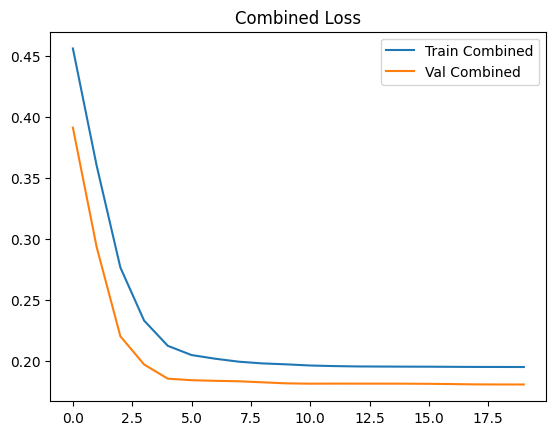

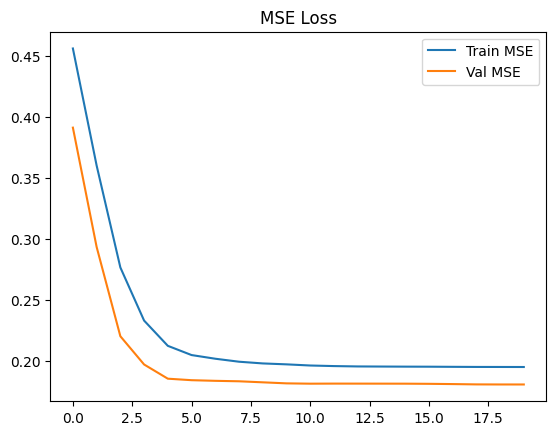

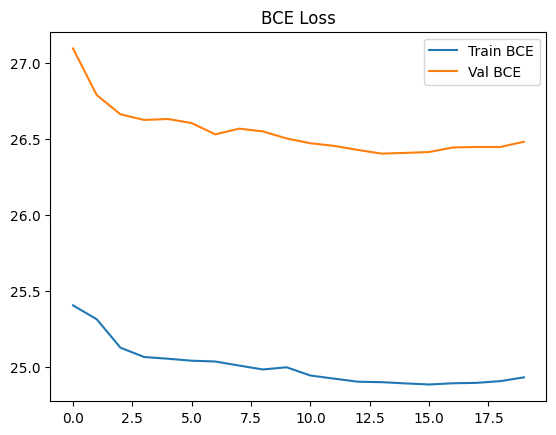

In [12]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0000001)

loss_fn1 = nn.MSELoss()
loss_fn2 = nn.BCELoss()

# Combined Loss = ALPHA * MSE + BETA * BCE
ALPHA = 1    # Weight of MSE Loss
BETA = 0    # Weight of BCE Loss

combined_history, mse_history, bce_history = train(model, [Events_training, Events_validation])

plt.plot(combined_history[:,0], label="Train Combined")
plt.plot(combined_history[:,1], label="Val Combined")
plt.title('Combined Loss')
plt.legend()
plt.show()
plt.plot(mse_history[:,0], label="Train MSE")
plt.plot(mse_history[:,1], label="Val MSE")
plt.title('MSE Loss')
plt.legend()
plt.show()
plt.plot(bce_history[:,0], label="Train BCE")
plt.plot(bce_history[:,1], label="Val BCE")
plt.title('BCE Loss')
plt.legend()
plt.show()

### Visualize Attention Scores

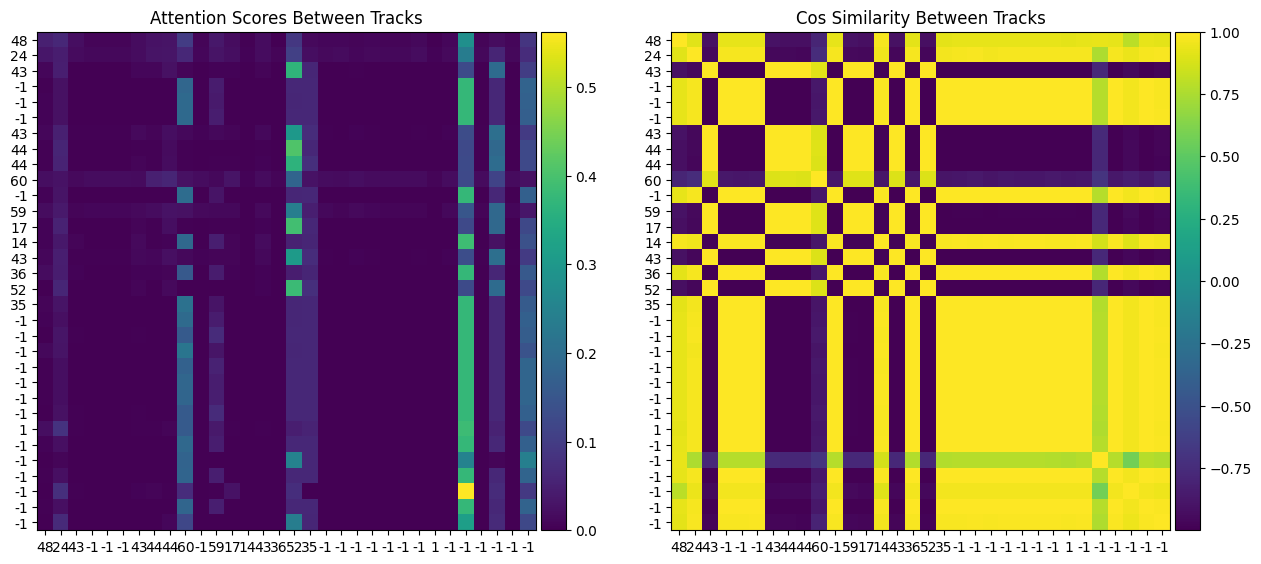

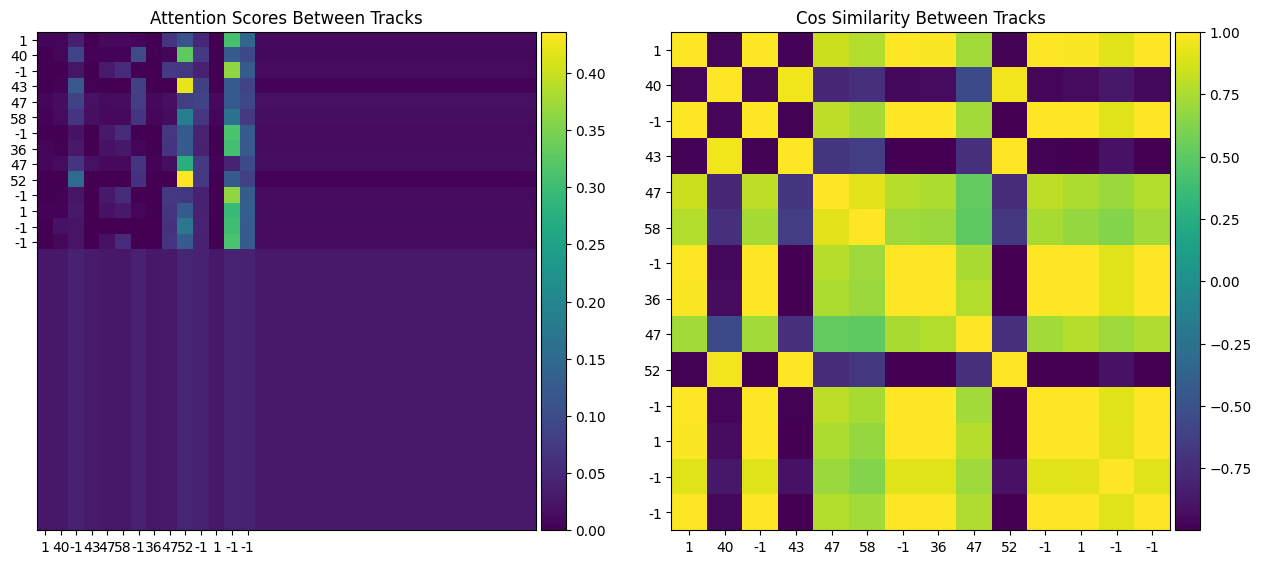

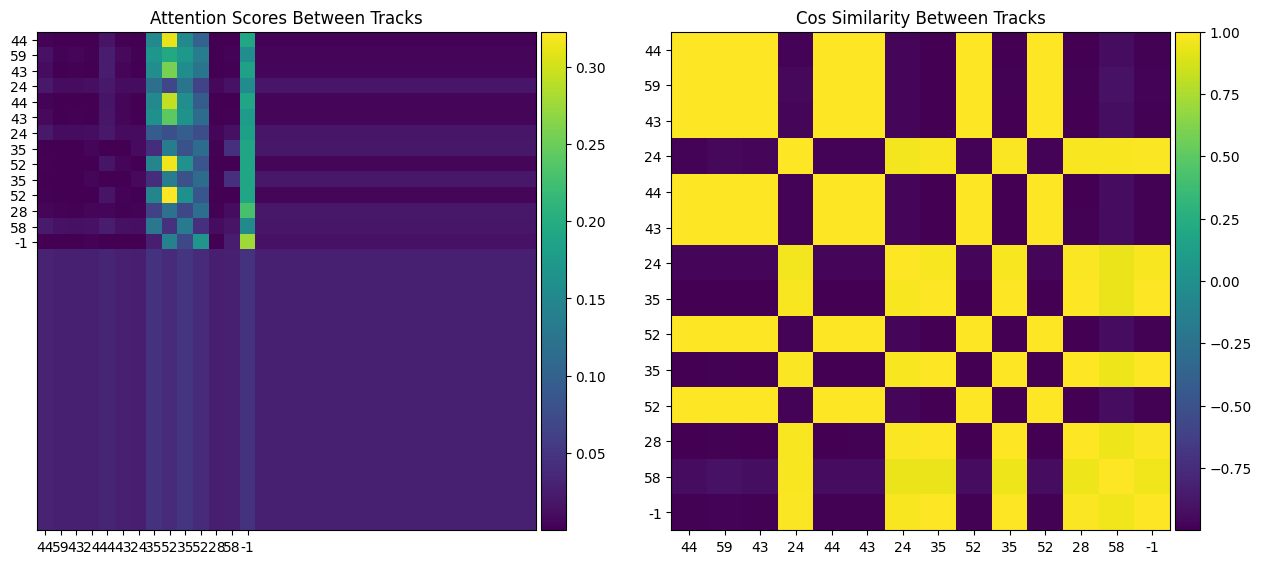

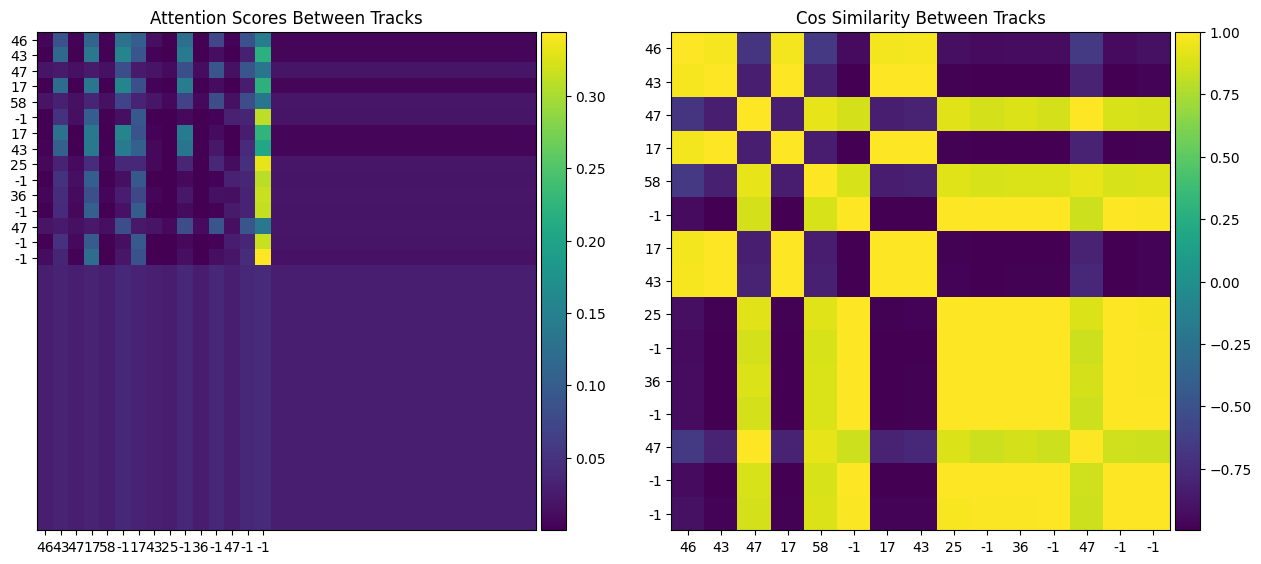

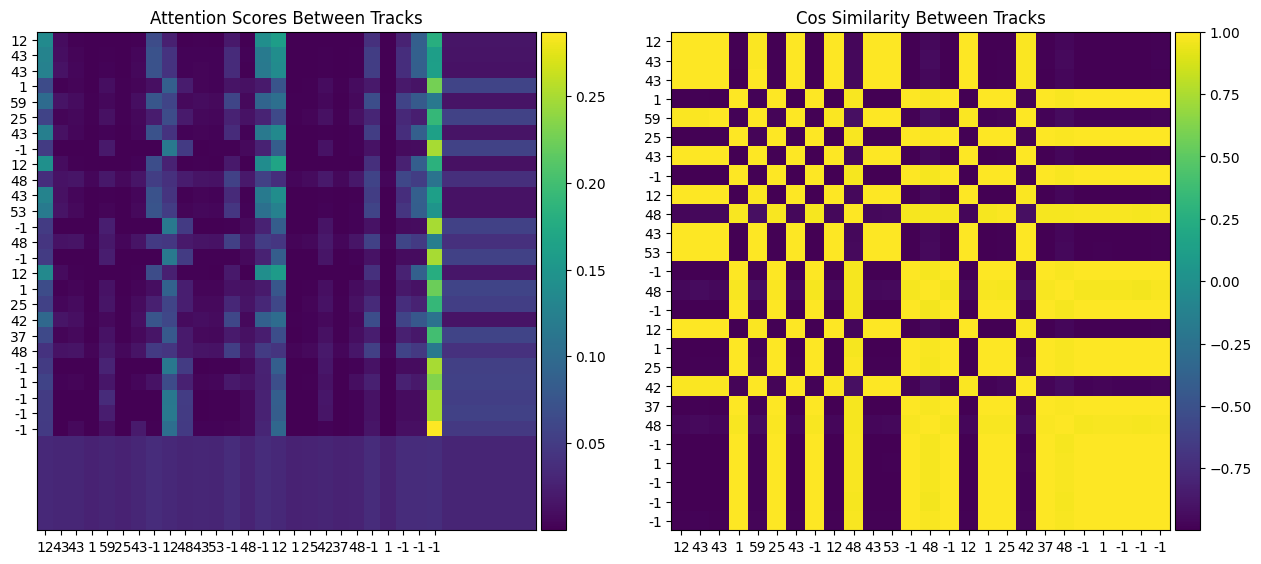

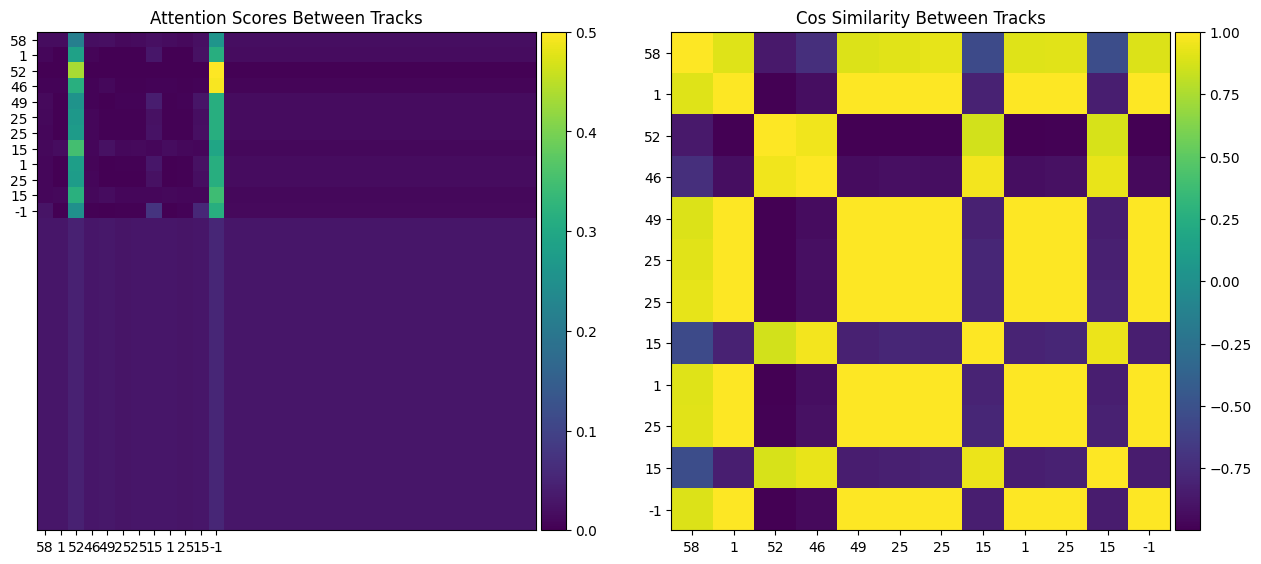

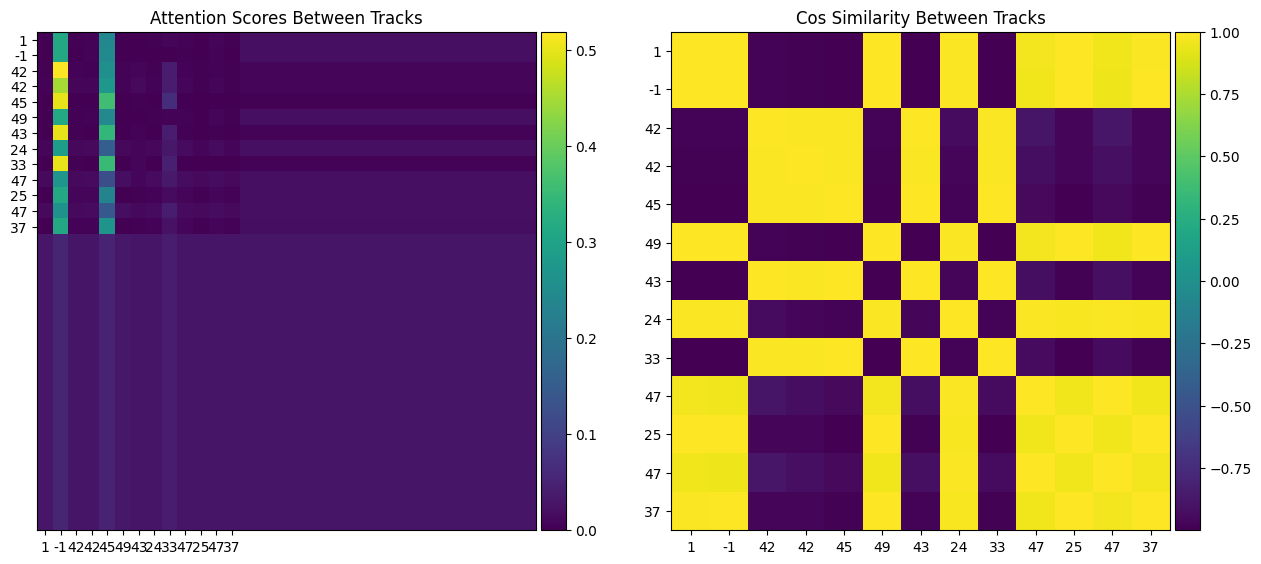

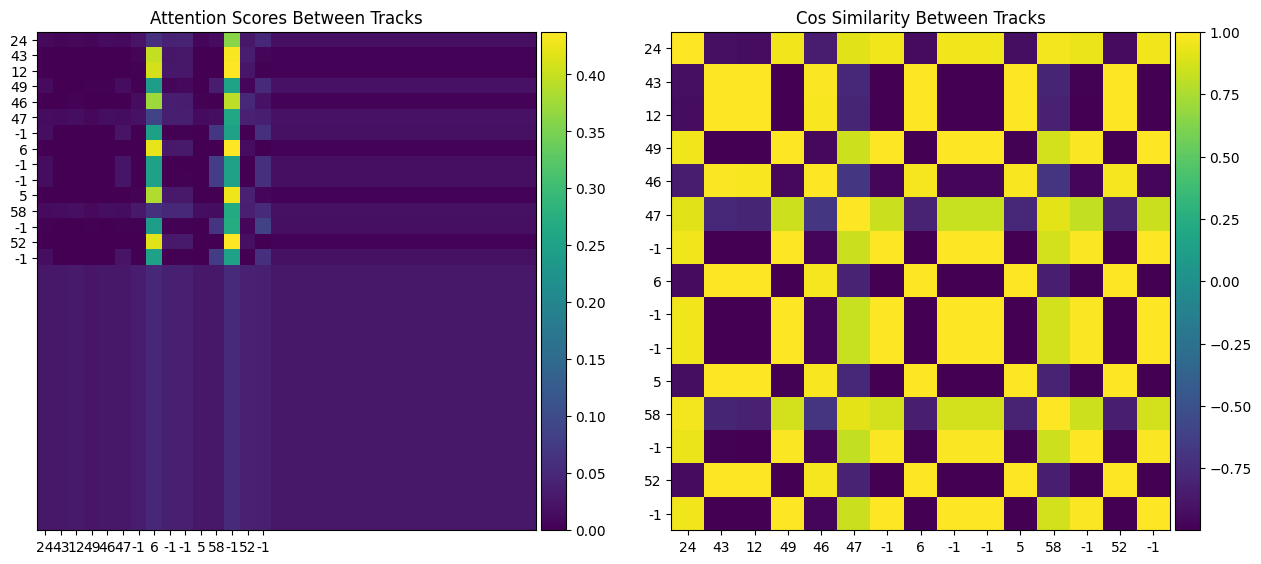

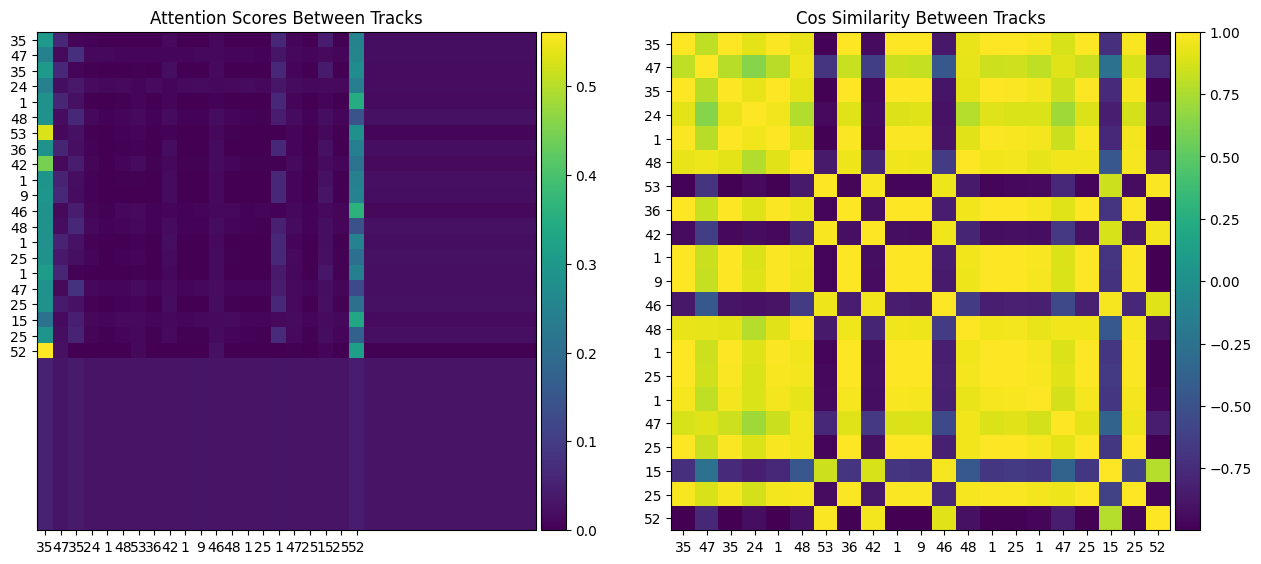

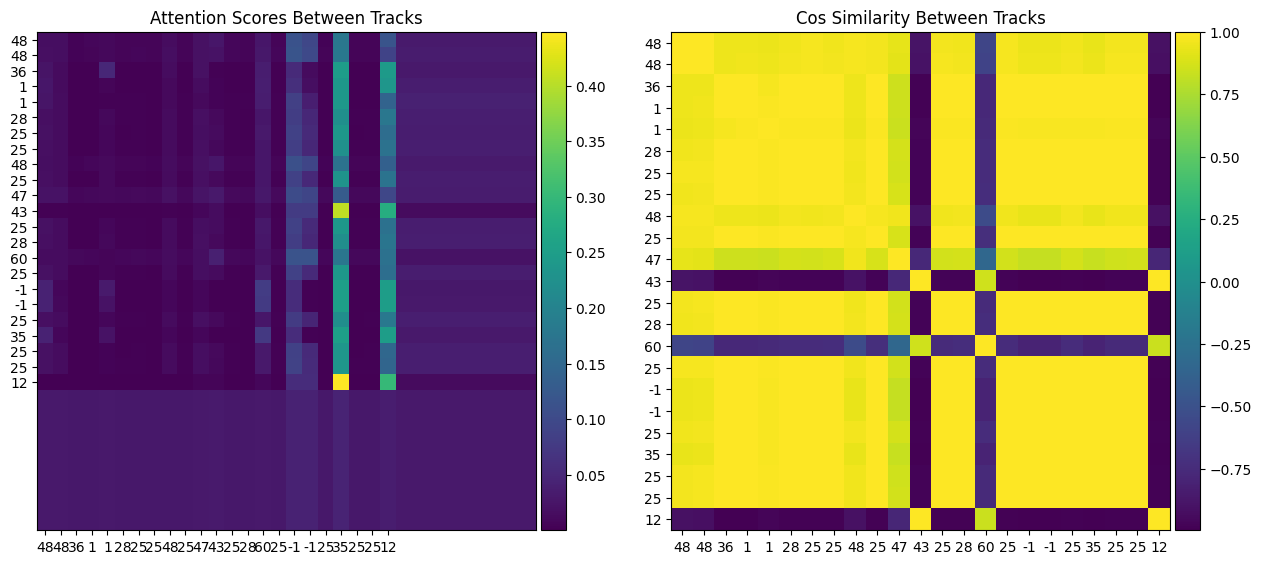

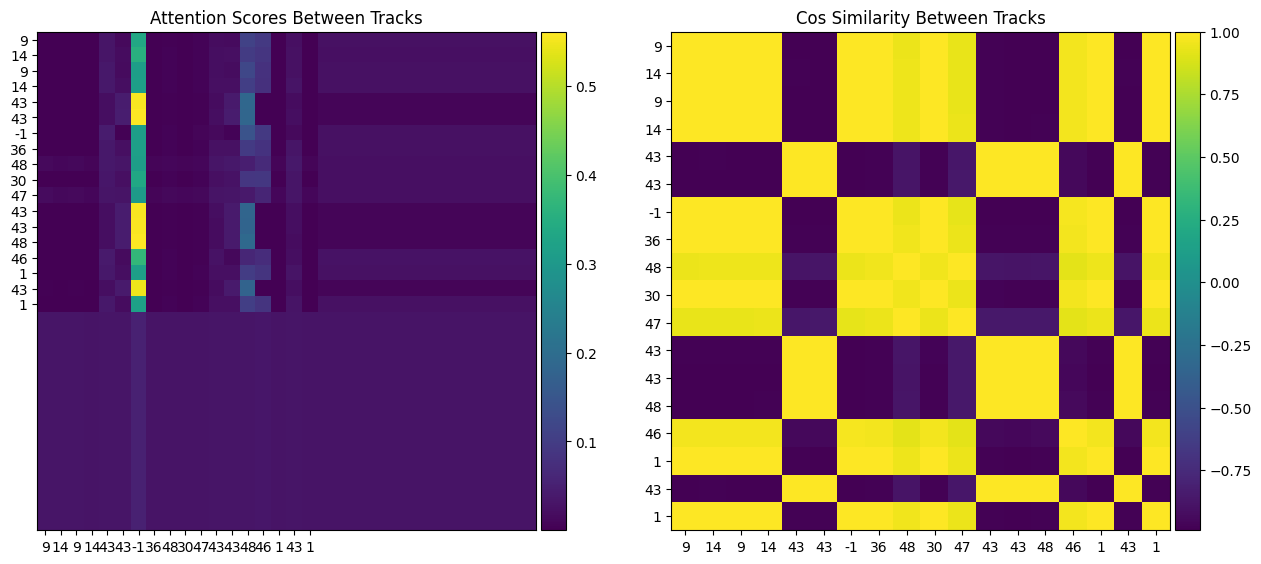

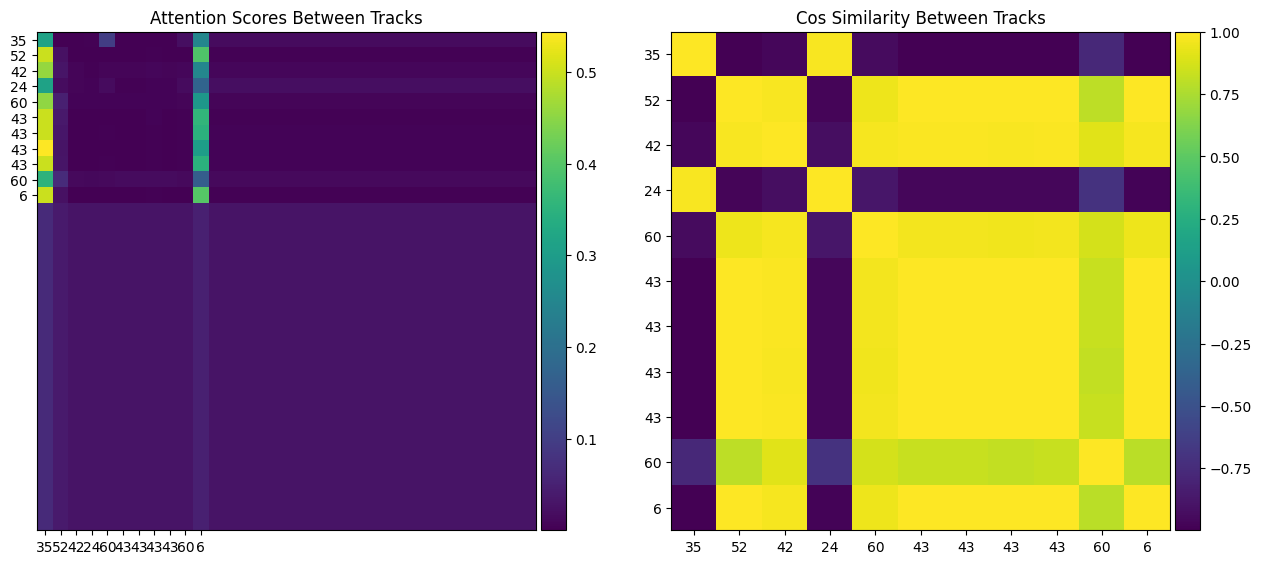

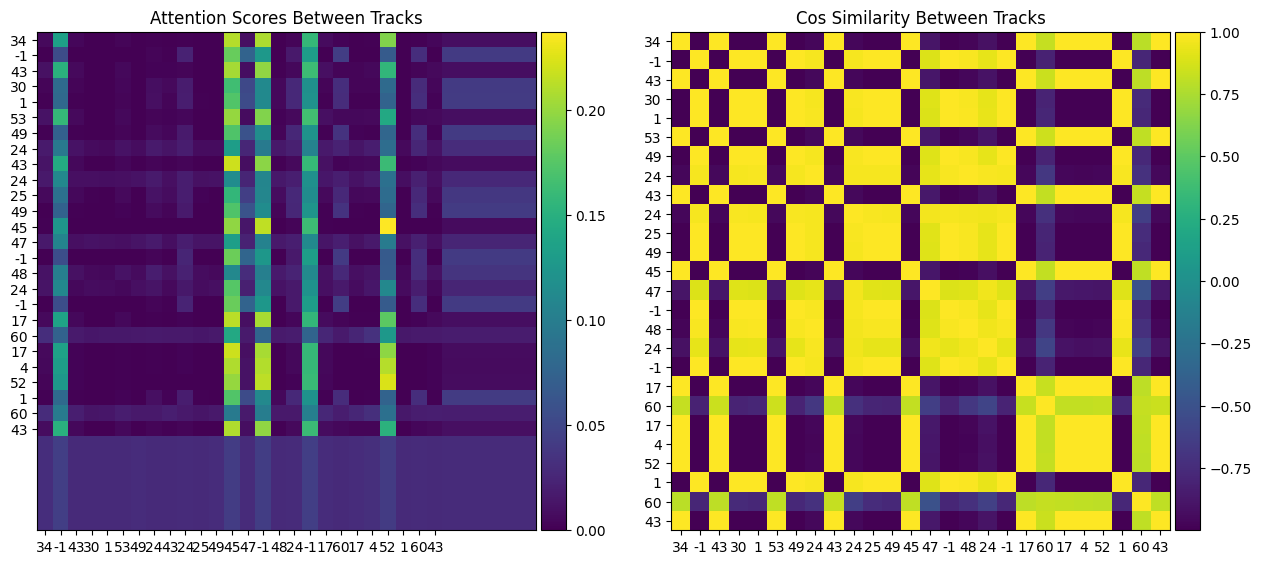

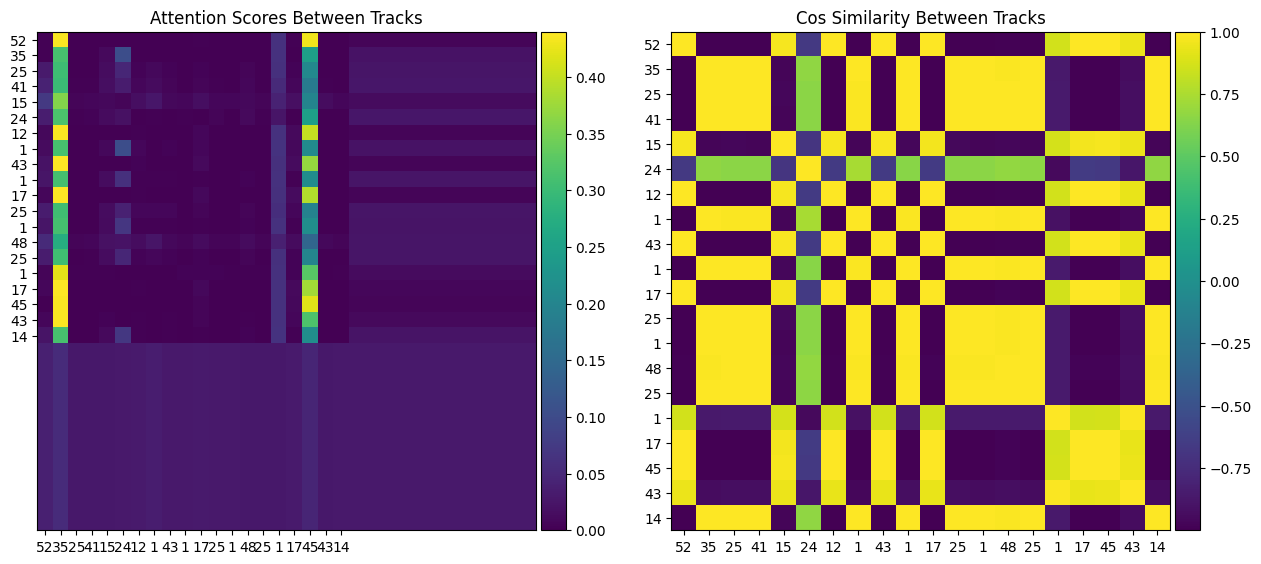

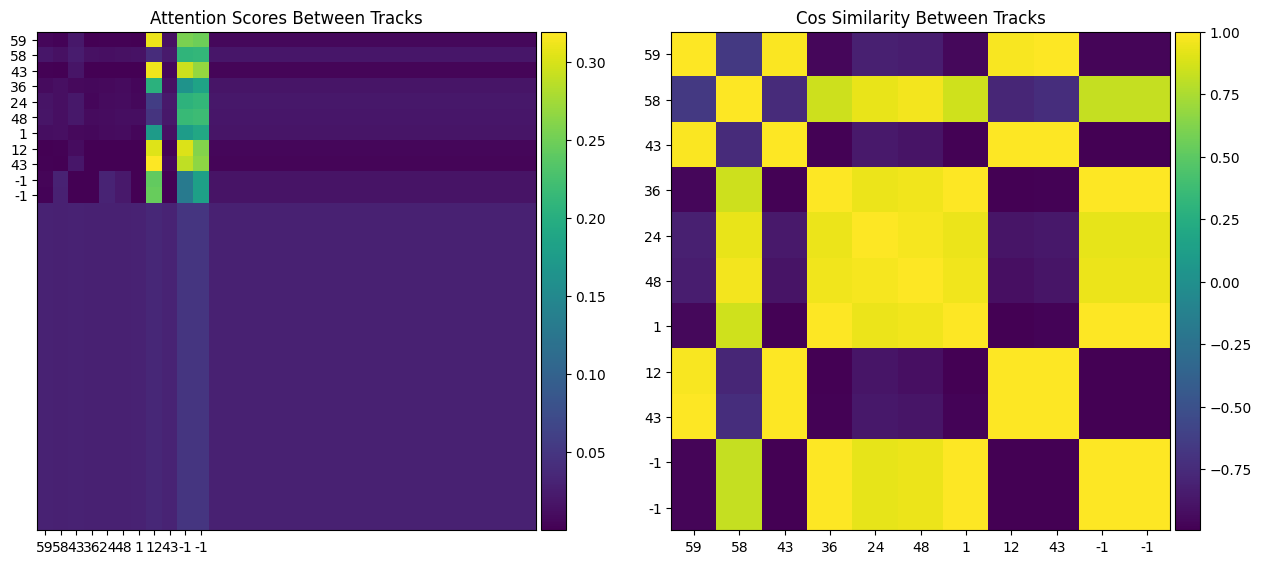

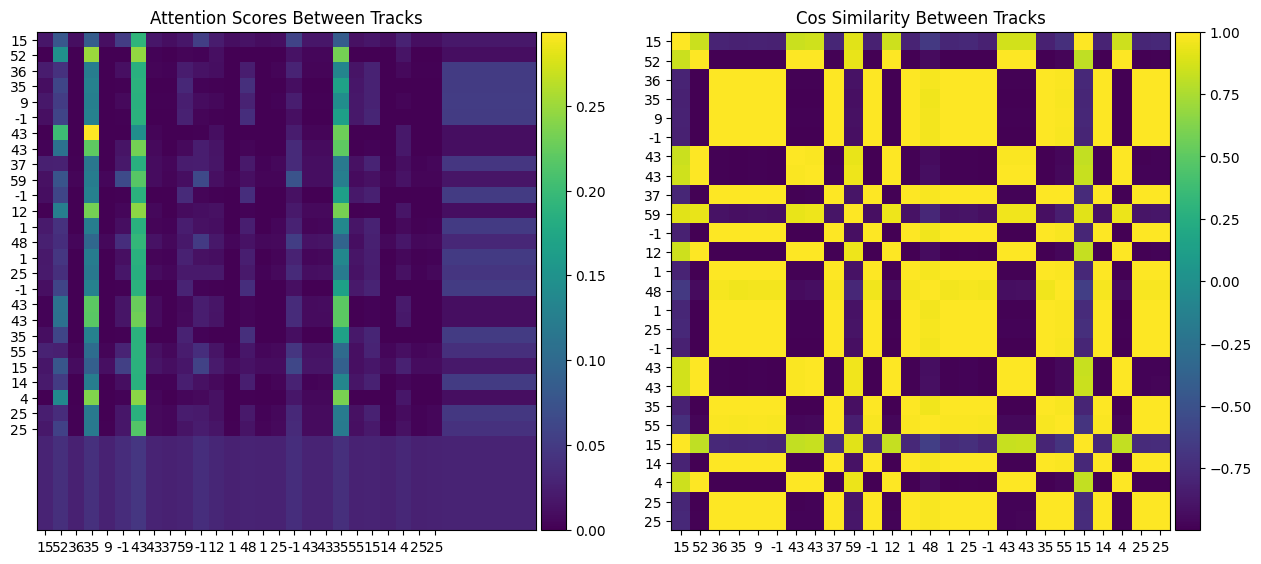

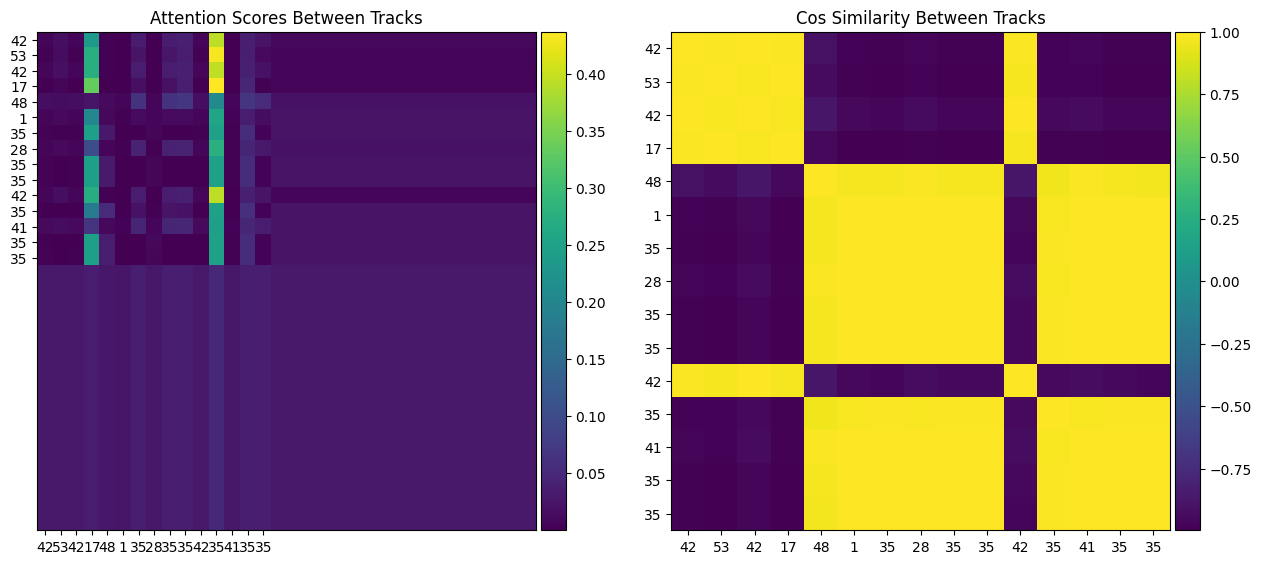

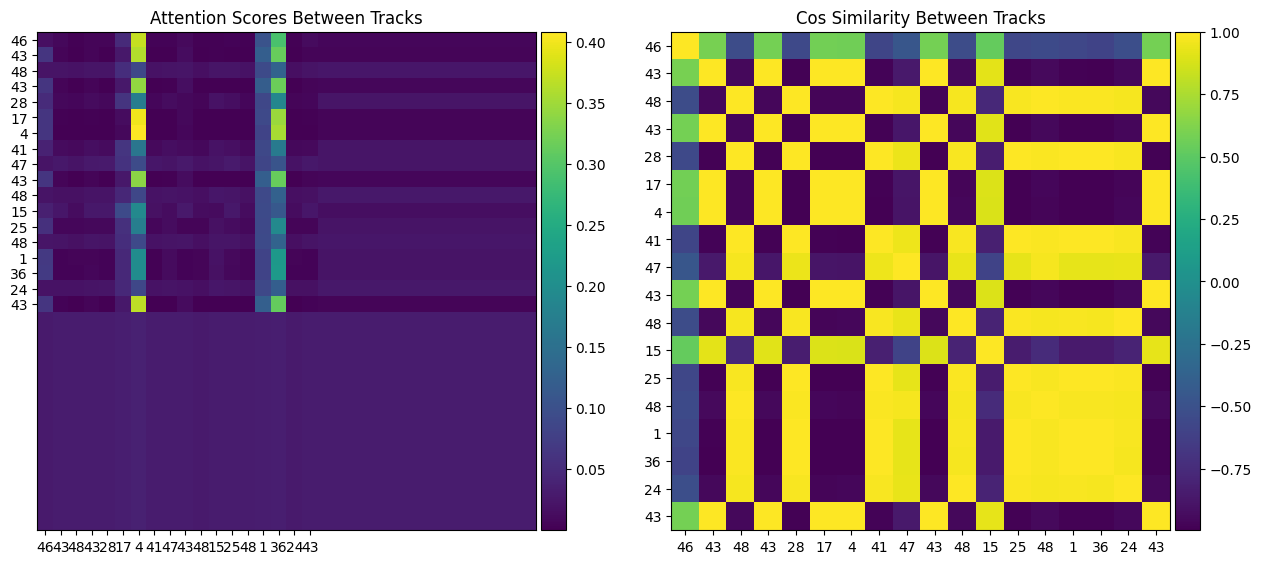

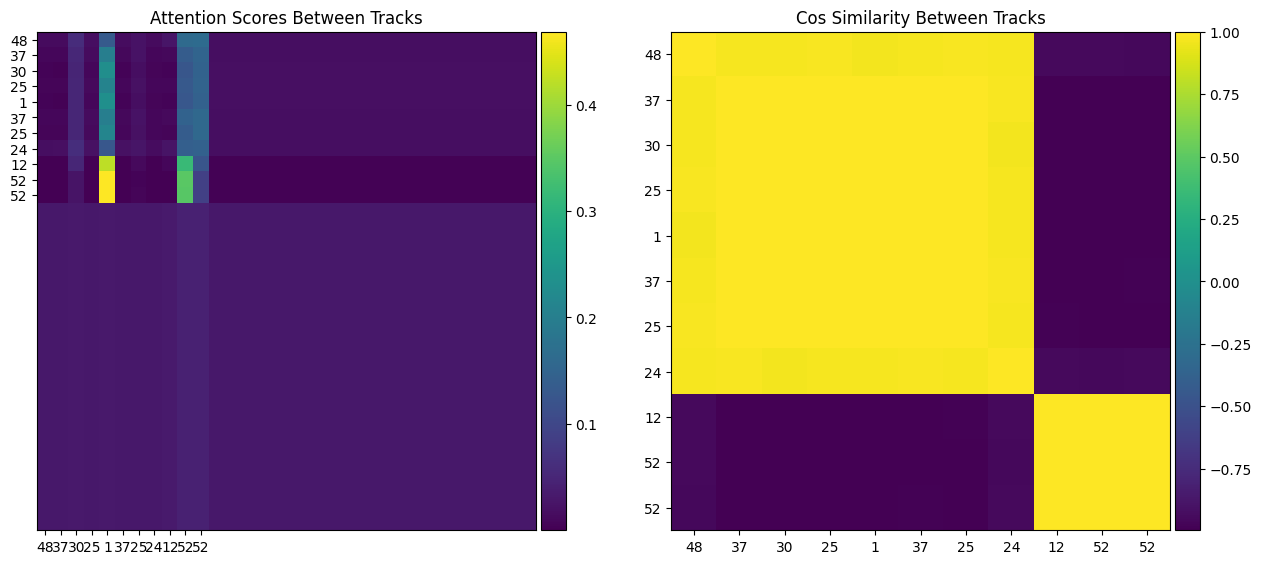

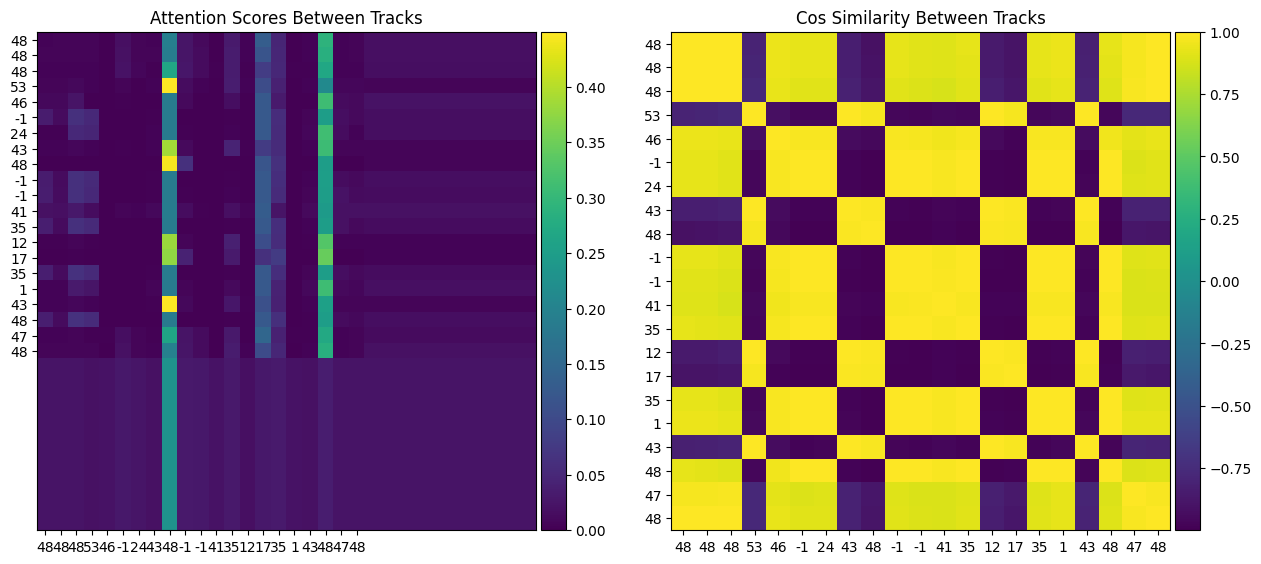

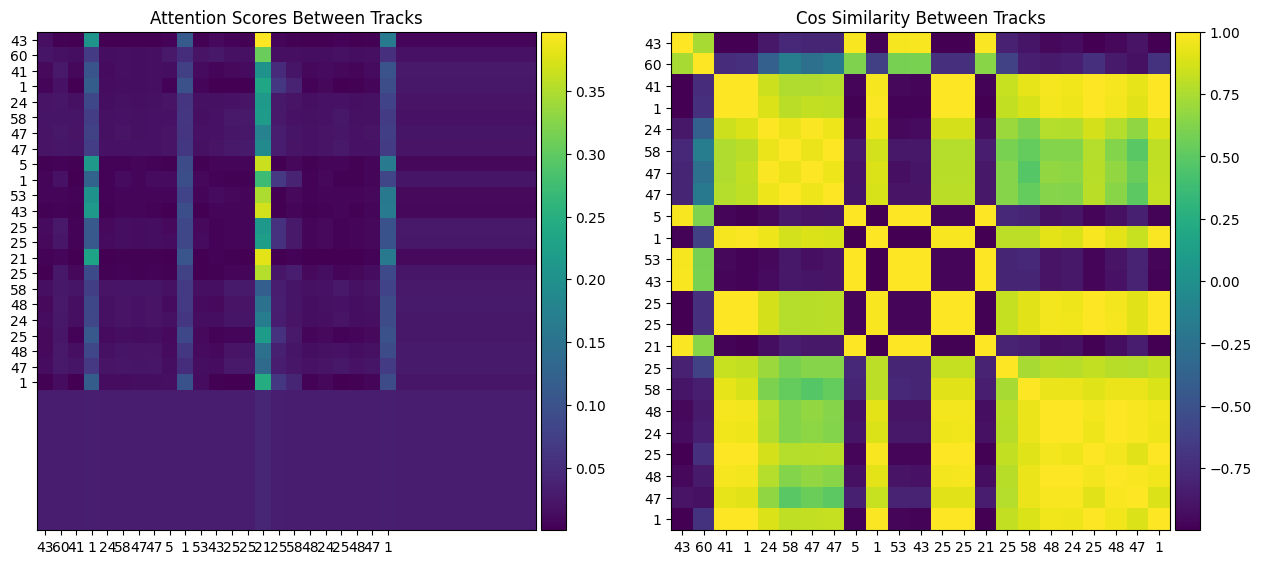

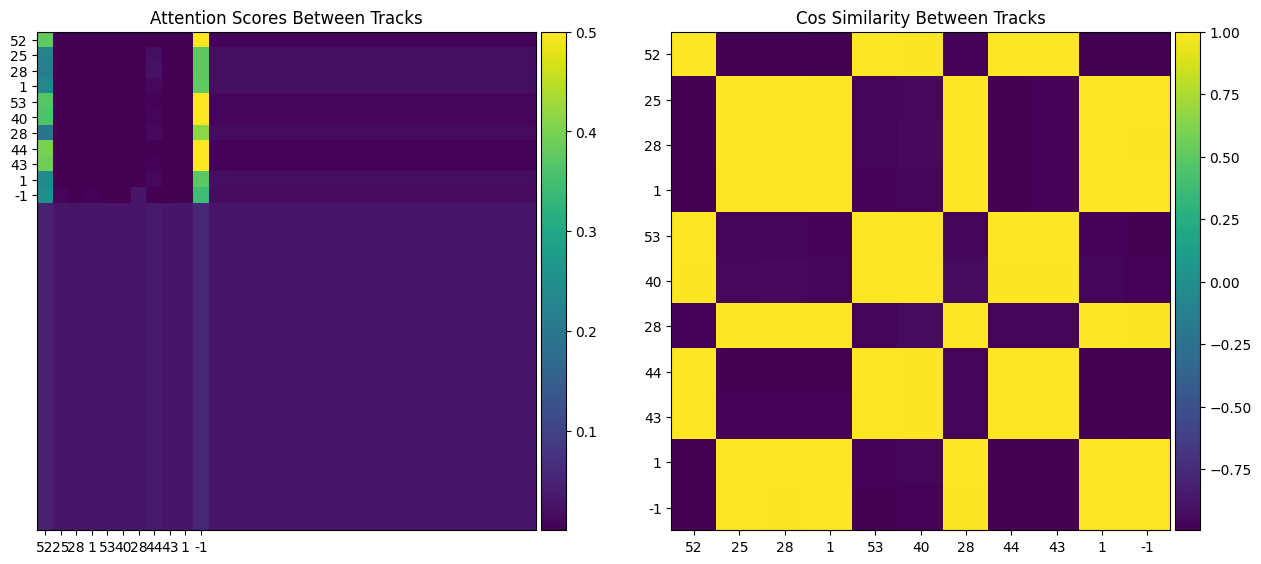

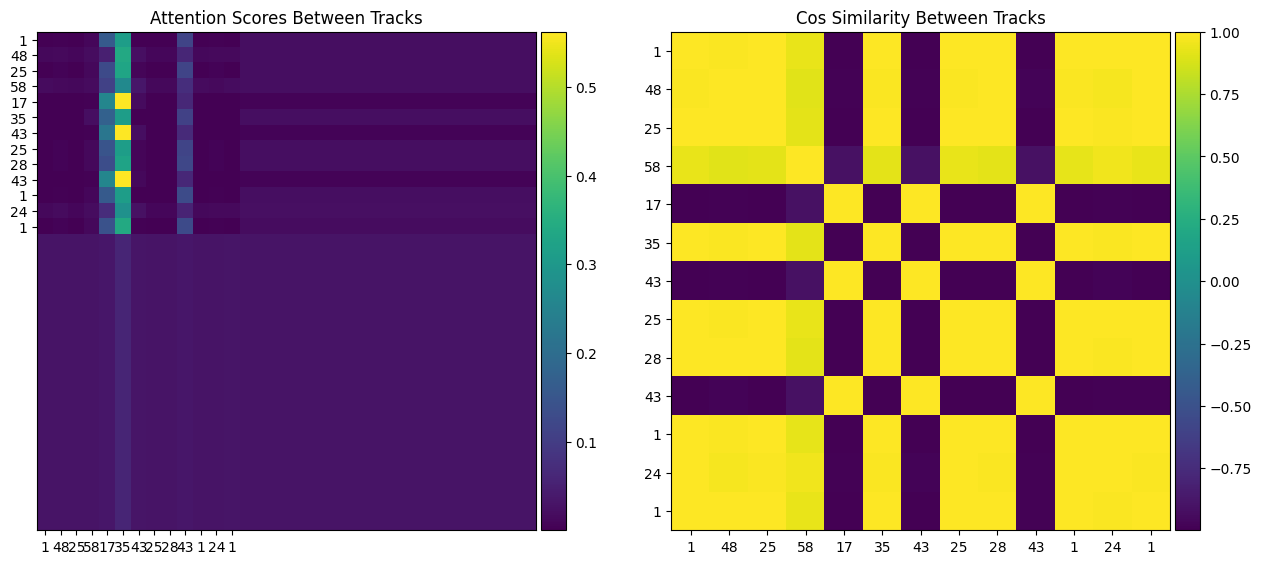

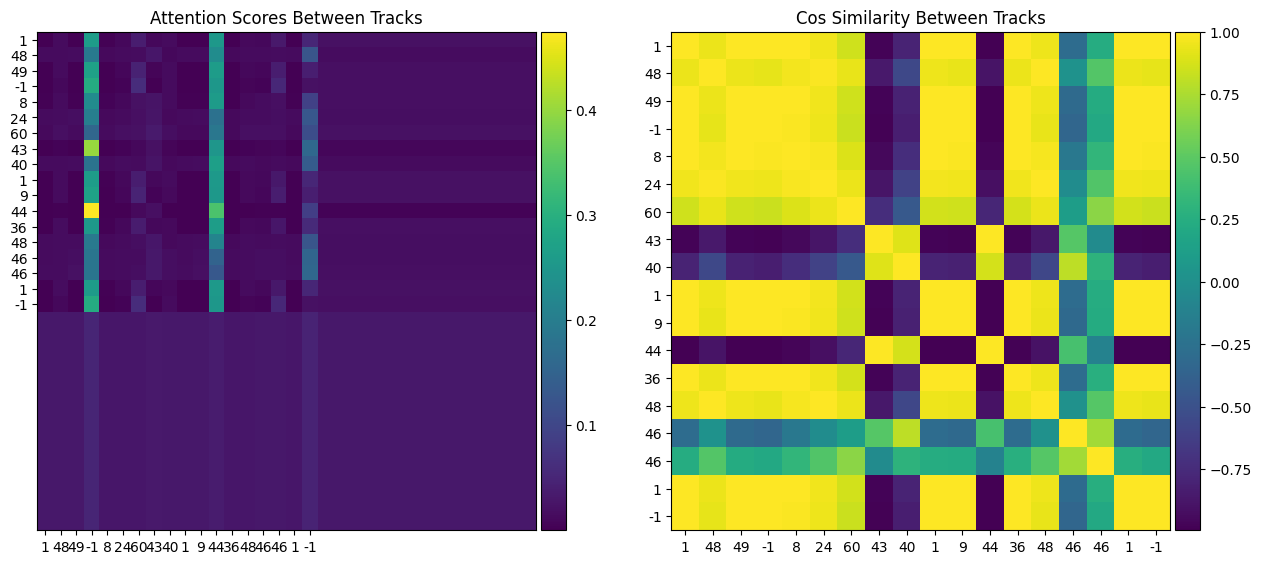

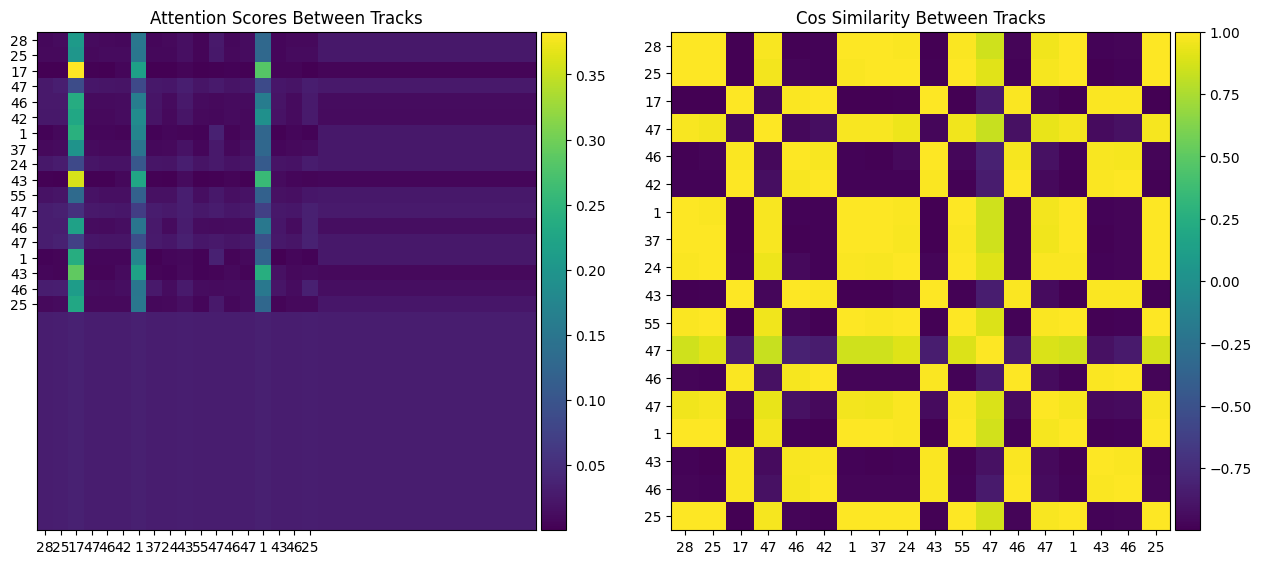

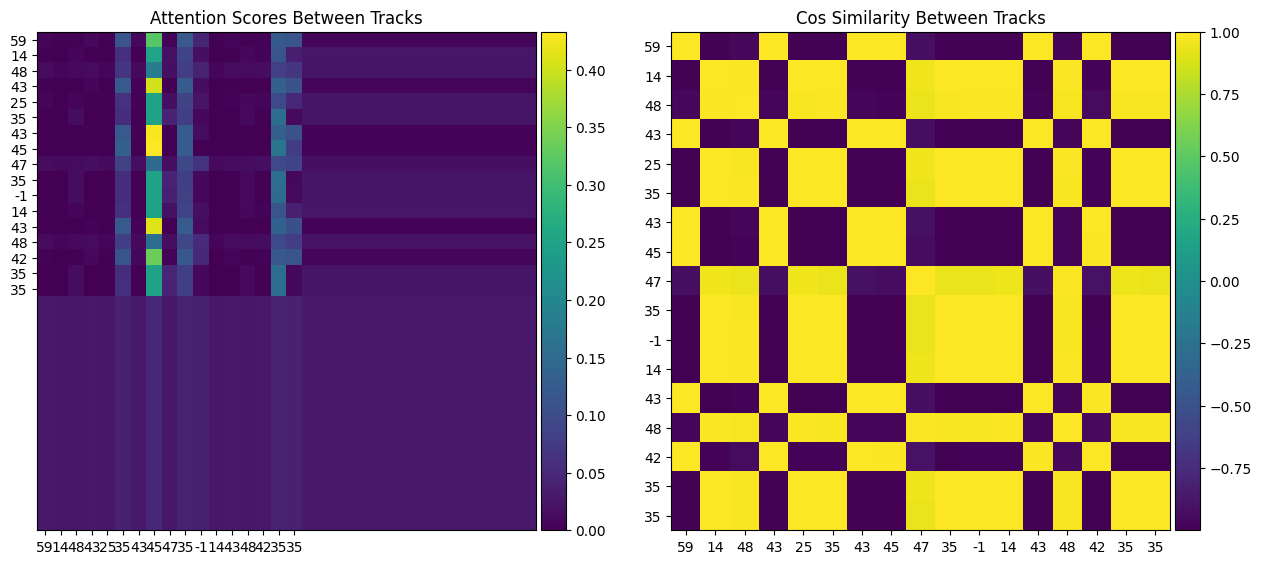

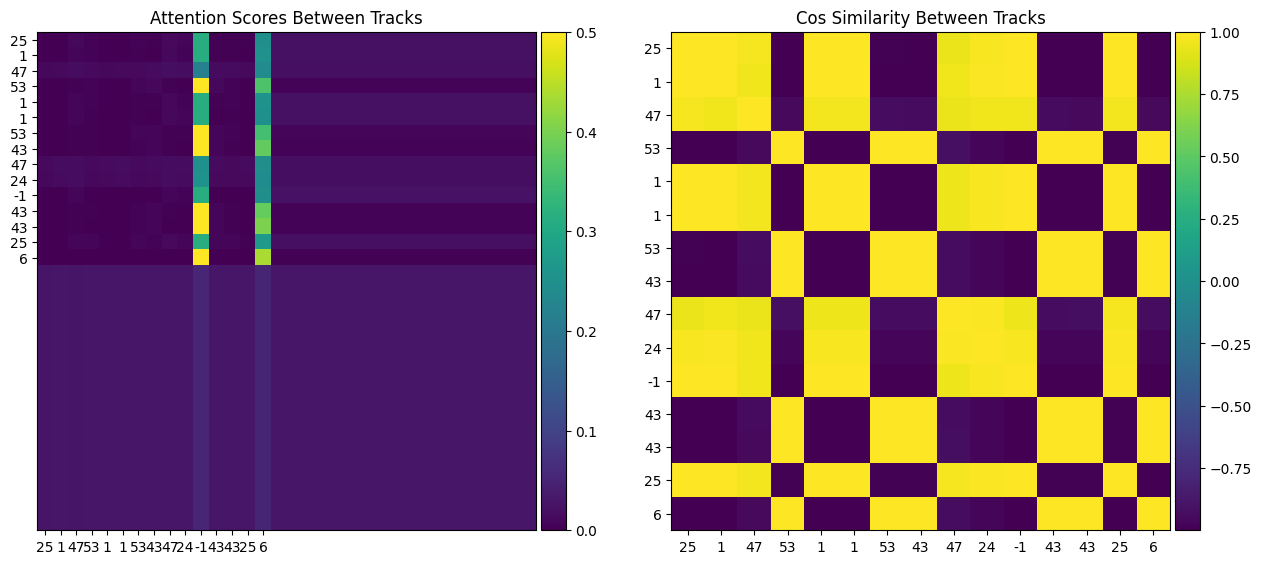

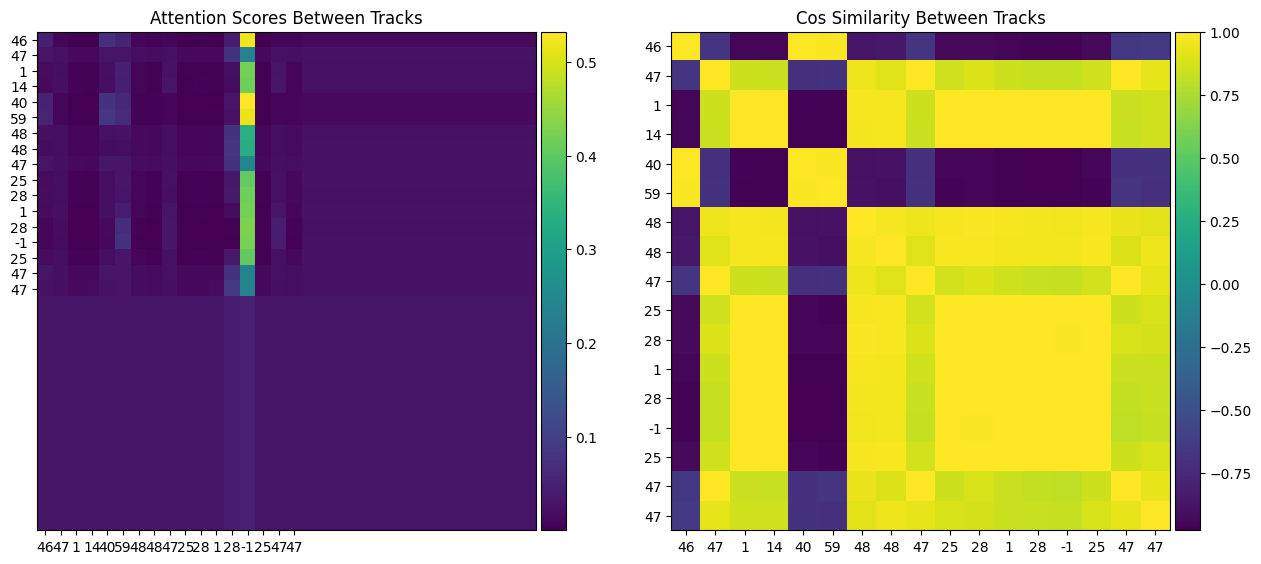

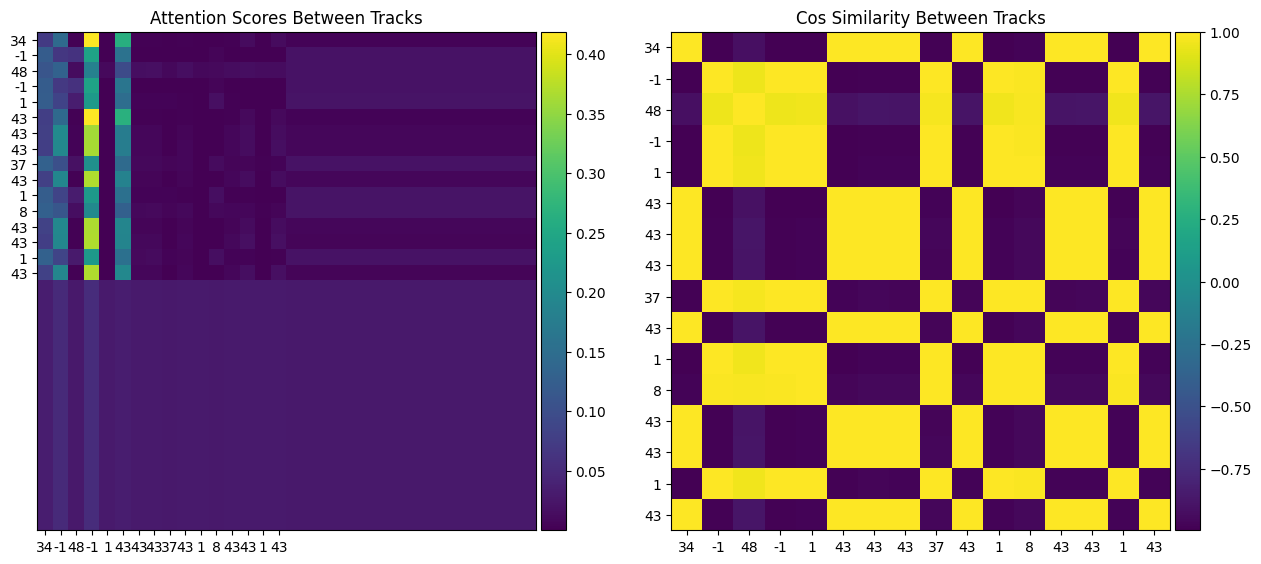

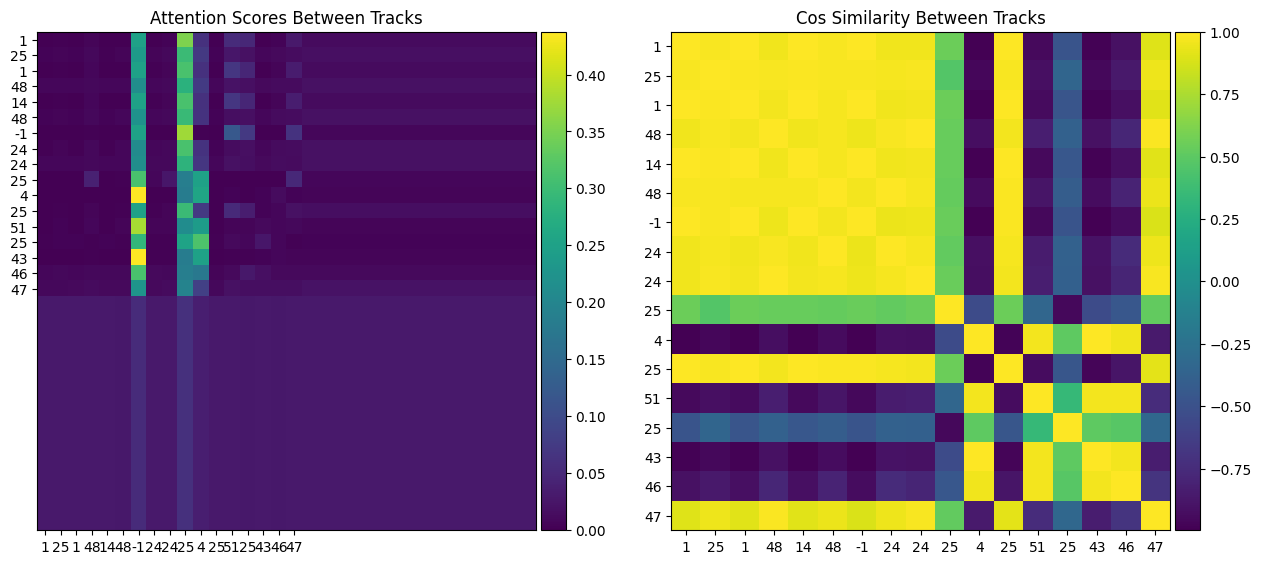

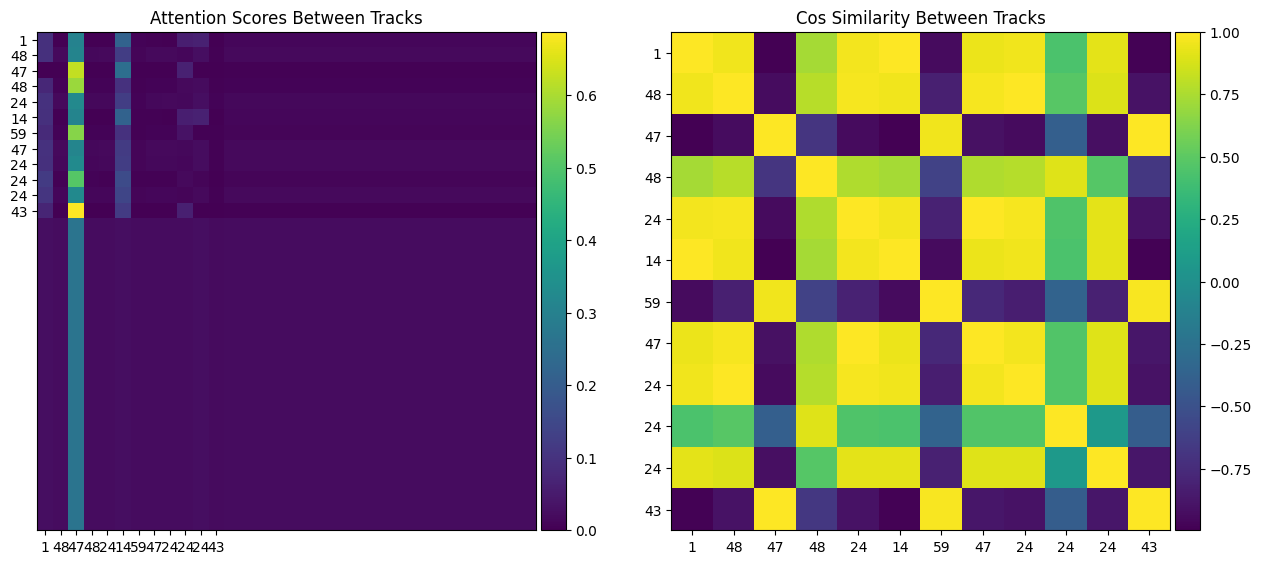

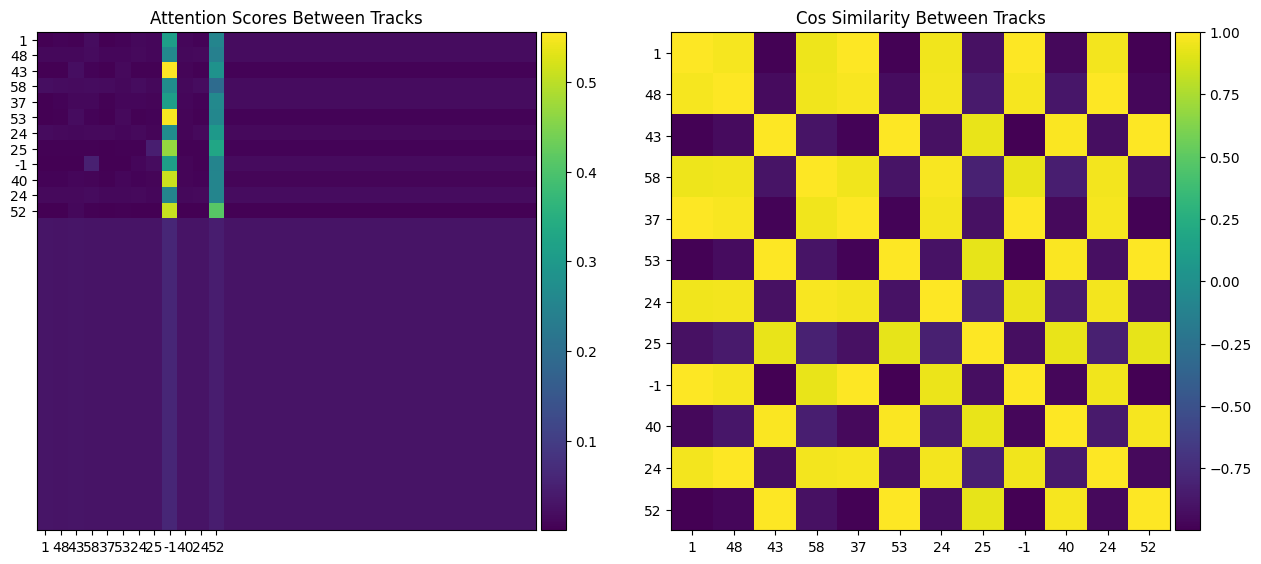

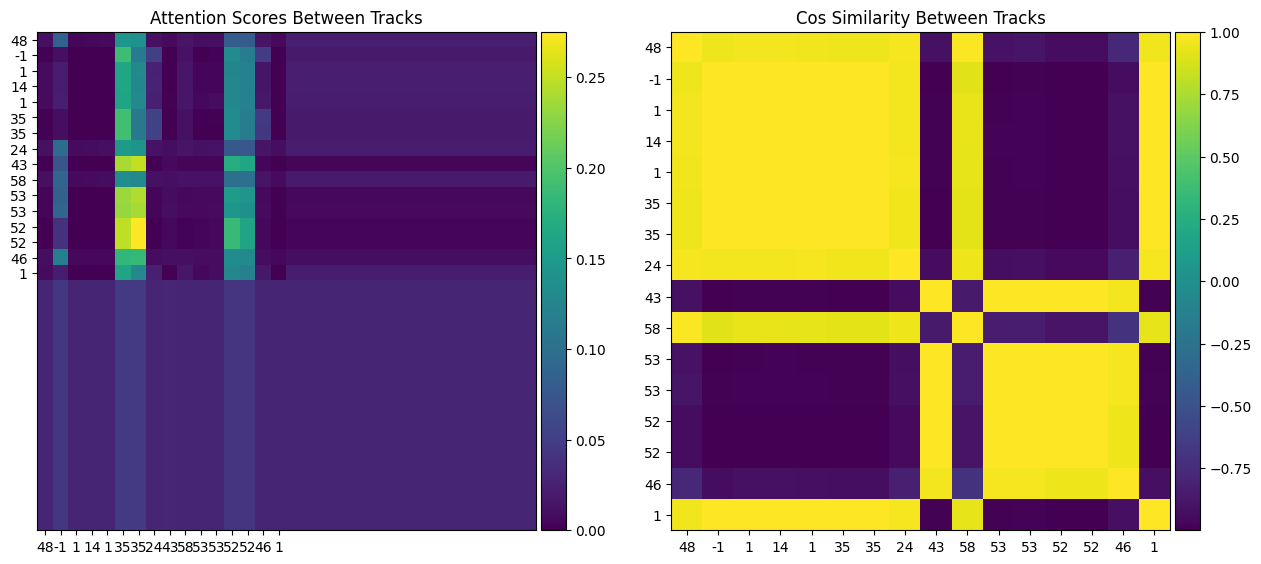

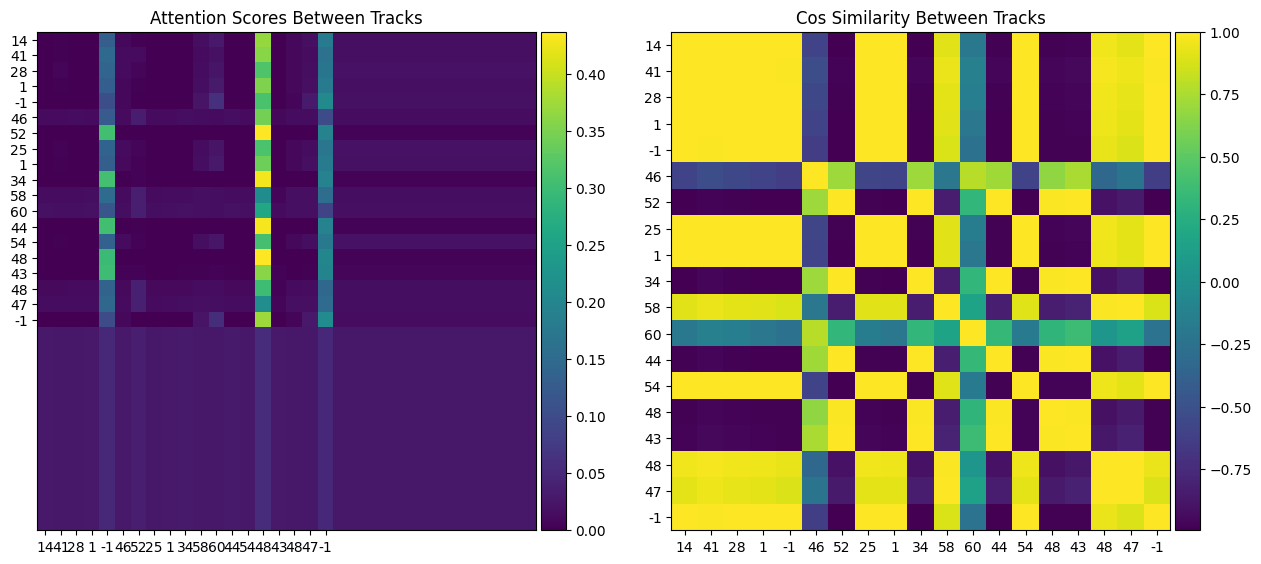

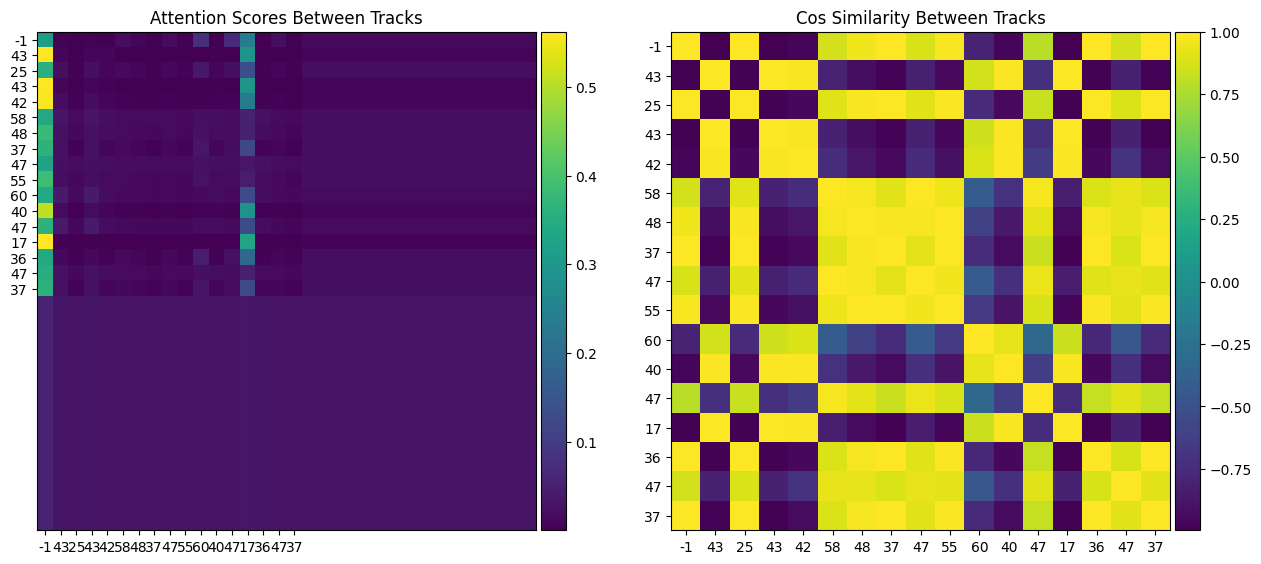

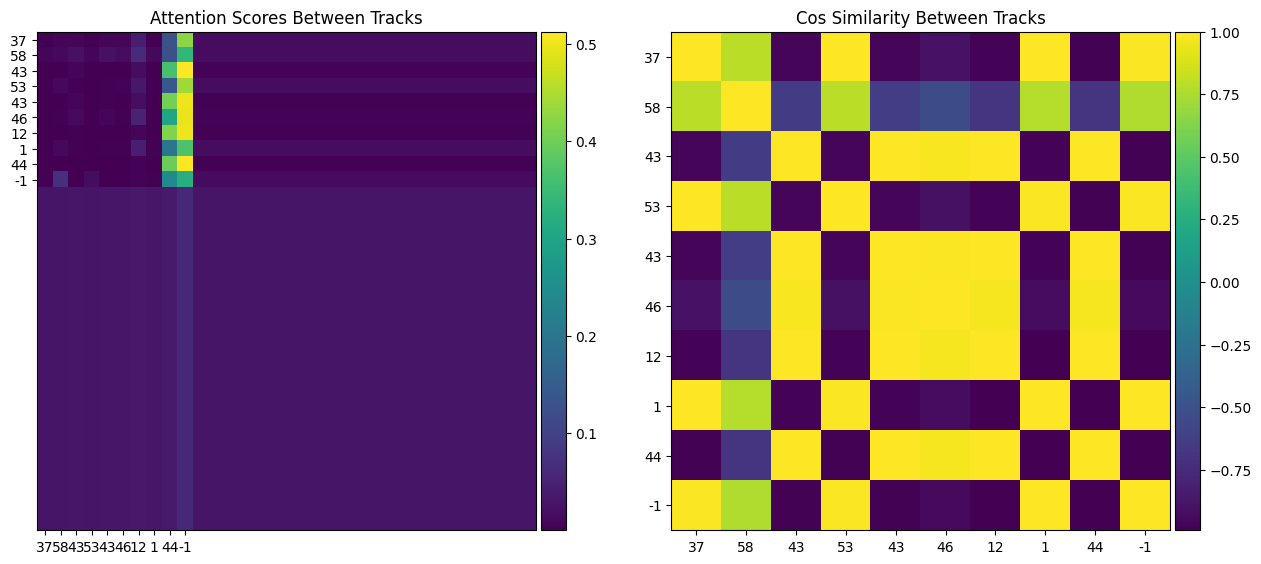

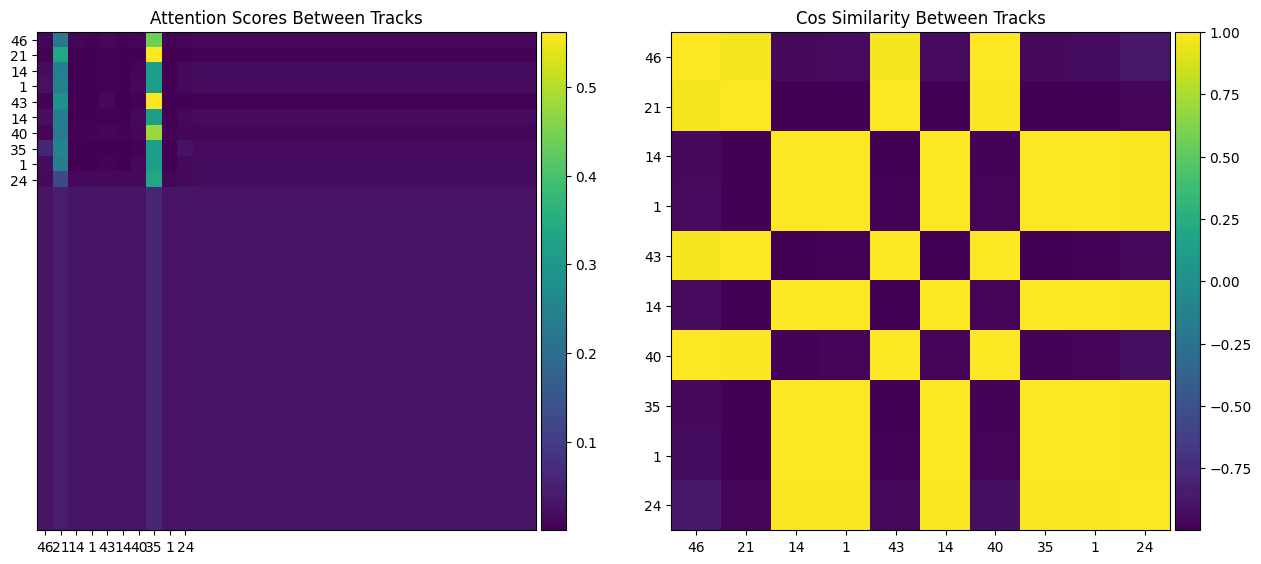

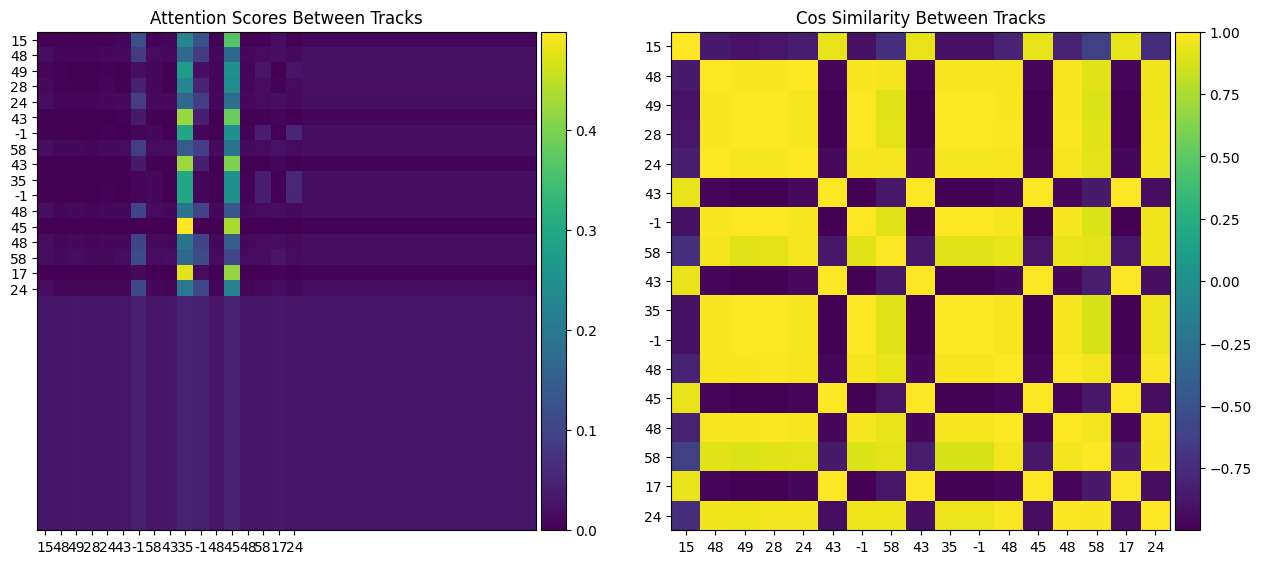

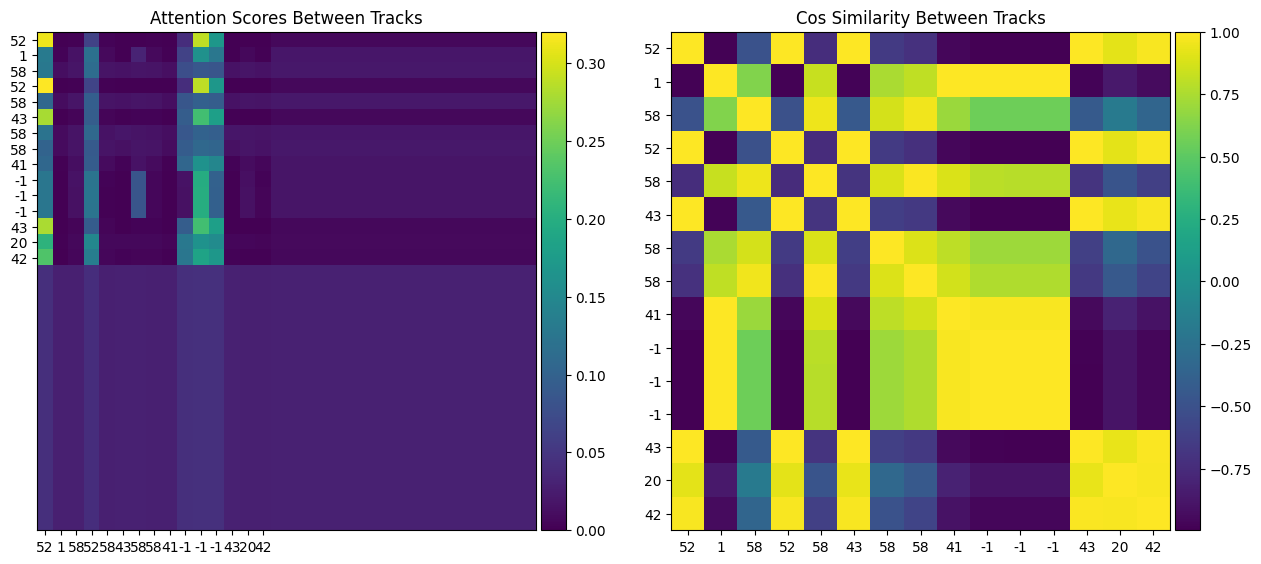

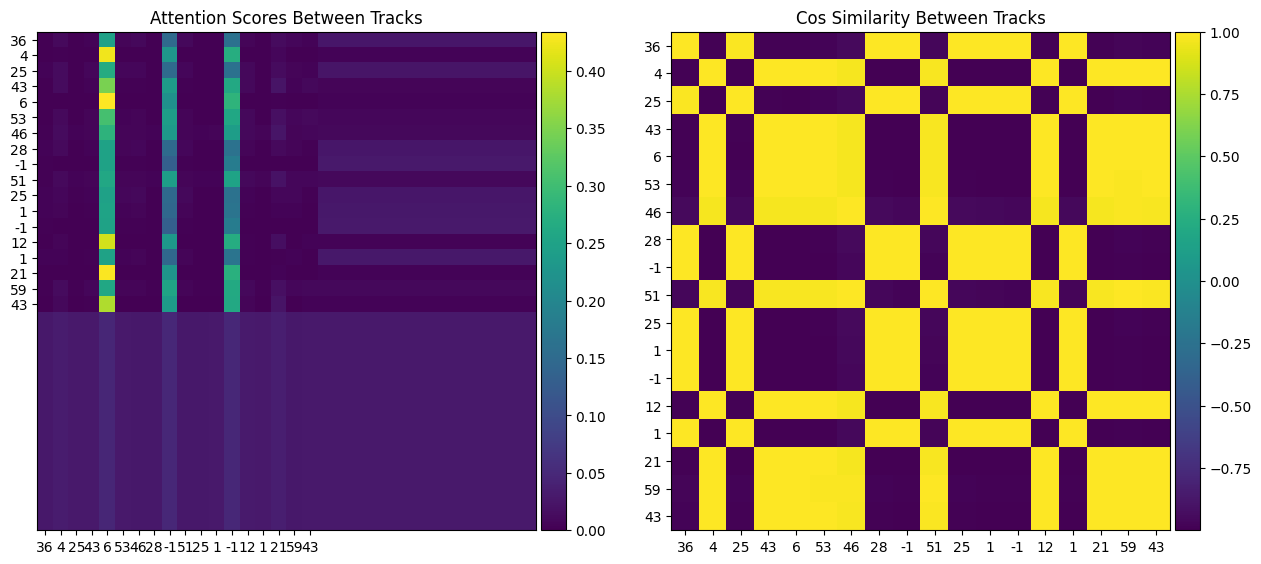

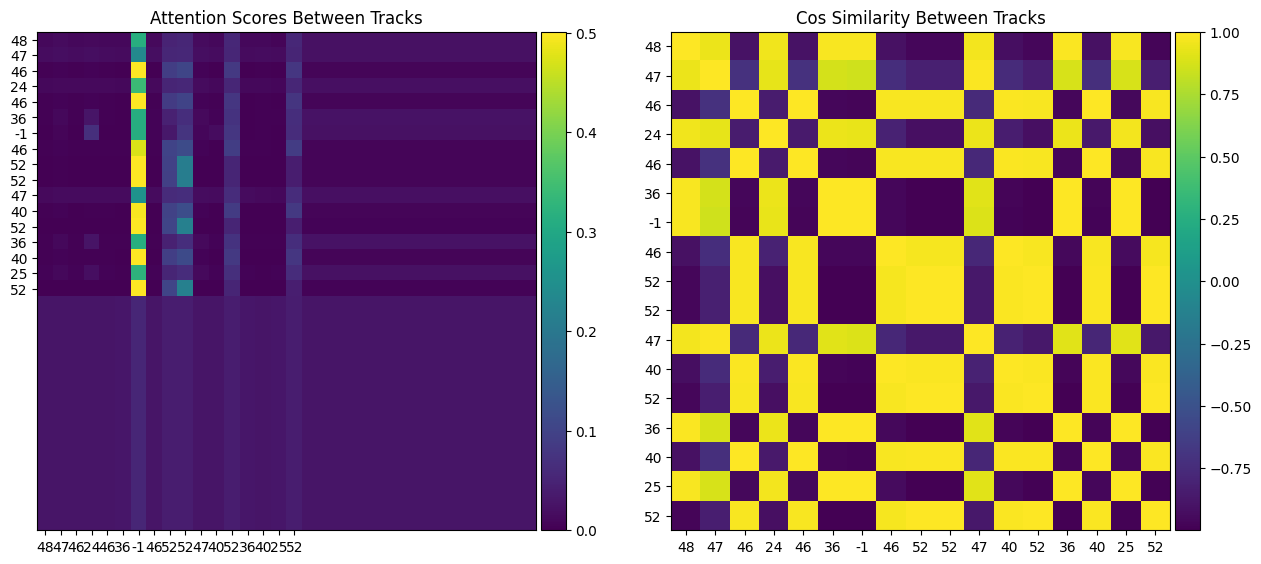

In [13]:
plotting_num=1
for i in range(plotting_num):
    #event_no, jet_no = hs_idx[i]
    
    jets_test, trks_test, test_labels, test_bin_labels = dataloader(Events_testing[i])
    
    # Get Model Predictions
    model.eval()
    output, binary, jet_weights, trk_weights = model(jets_test.to(device), trks_test.to(device))
    
    # Calculate tick labels
    num_jets = len(output)
    num_trks = len(Events_testing[i][0].trk_features)
    for j in range(num_jets):
        # Define subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        tick_labels = []
        num_trks = len(Events_testing[i][j].trk_labels)
        ticks = [x for x in range(num_trks)]
        for trk in range(num_trks):
            tick_labels.append(int(Events_testing[i][j].trk_labels[trk]))
    
        # Plot attention weights
        im1 = ax1.imshow(trk_weights[j].detach().cpu().numpy())
        ax1.set_xticks(ticks, tick_labels)
        ax1.set_yticks(ticks, tick_labels)
        ax1.set_title("Attention Scores Between Tracks")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')

        # Calculate cos similiarity matrix
        cos_sim_matrix = np.zeros((num_trks,num_trks))
        for u in range(num_trks):
            feats1 = Events_testing[i][j].trk_features[u].numpy()
            A = np.linalg.norm(feats1)
            for v in range(u,num_trks):
                feats2 = Events_testing[i][j].trk_features[v].numpy()
                B = np.linalg.norm(feats2)
                cos_sim_matrix[u,v] = np.dot(feats1,feats2) / (A*B)
                cos_sim_matrix[v,u] = cos_sim_matrix[u,v]

        # Plot cos similiarity matrix
        im2 = ax2.imshow(cos_sim_matrix)  
        ax2.set_xticks(ticks, tick_labels)
        ax2.set_yticks(ticks, tick_labels)
        ax2.set_title("Cos Similarity Between Tracks")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        plt.show()    

### Evaluate Model

Train Loss:	 0.19502573671440285
Val Loss:	 0.18070410519838334
Test Loss:	 1.2541469640848113


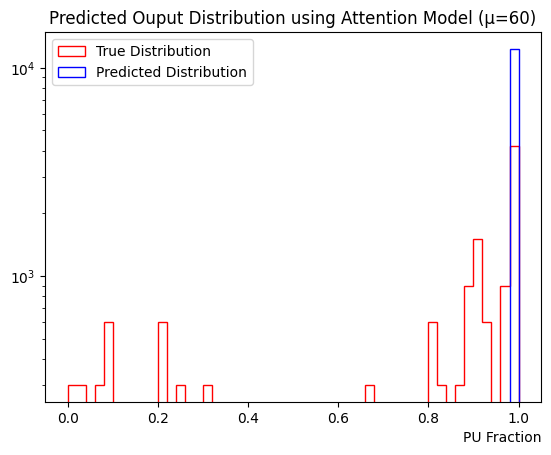

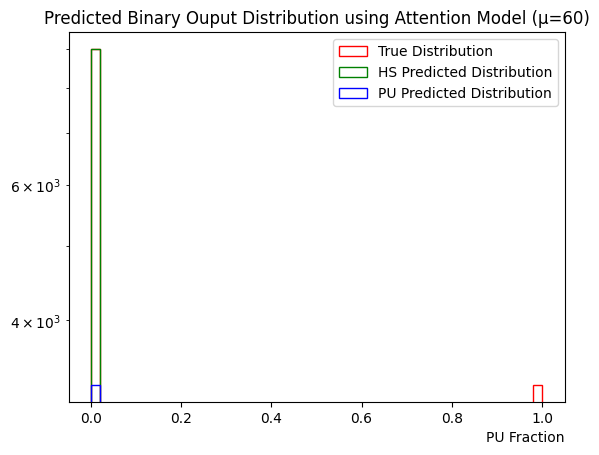

In [14]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(Events_testing)
for i in range(num_test):
    output, binary, jet_weights, trk_weights = model(jets_test.to(device), trks_test.to(device))
    
    for i in range(output.shape[0]):        
        predicted_labels.append(1-float(output[i][0].detach().cpu().numpy()))
        true_labels.append(1-float(test_labels[i][0].detach().numpy()))
        binary_pred.append(1-float(binary[i][0].detach().cpu().numpy()))
        binary_true.append(1-float(test_bin_labels[i][0].detach().numpy()))
    
    loss_MSE=loss_fn1(output, test_labels.to(device))
    loss_BCE=loss_fn2(binary, test_bin_labels.to(device))
    loss = ALPHA * loss_MSE + BETA * loss_BCE
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
    
cumulative_loss_test = cumulative_loss_test / len(test_labels)
"""
        jets_test, trks_test, test_labels, test_bin_labels = dataloader(Events_testing[i])
        output, binary, jet_weights, trk_weights = model(jets_test.to(device), trks_test.to(device))
        loss_MSE=loss_fn1(output, test_labels.to(device))
        loss_BCE=loss_fn2(binary, test_bin_labels.to(device))
        loss = ALPHA * loss_MSE + BETA * loss_BCE
        cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        cumulative_MSE_test+=loss_MSE.detach().cpu().numpy().mean()
        cumulative_BCE_test+=loss_BCE.detach().cpu().numpy().mean()
        
        cumulative_loss_test = cumulative_loss_test / num_test
        cumulative_MSE_test = cumulative_MSE_test / num_test
        cumulative_BCE_test = cumulative_BCE_test / num_test
"""
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

binary_true = np.array(binary_true)
binary_pred = np.array(binary_pred)
PU_idxs = np.where(binary_true == 1)
HS_idxs = np.where(binary_true == 0)

plt.hist(binary_true,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(binary_pred[HS_idxs],histtype='step',color='g',label='HS Predicted Distribution',bins=50,range=(0,1))
plt.hist(binary_pred[PU_idxs],histtype='step',color='b',label='PU Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Binary Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()